## Notebook for the Viszualization of Singular vectors in 3d for 1H Data

### ToDo:
    - Documentation
    - fix paths

In [1]:
import pandas as pd
import os
import errno  # handy system and path functions
import sys  # to get file system encoding
import glob
import locale
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib import rcParams
params = {'legend.fontsize': 20,
          'legend.handlelength': 2,
         'figure.autolayout': True}
rcParams.update(params)
from scipy import signal
from scipy import stats
from sklearn import preprocessing

# np.set_printoptions(precision=28)
# pd.set_option('precision', 28)


# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_context("paper")
sns.set_style('whitegrid')
sns.set_palette('colorblind')

/home/michael/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# # Set the style globally

# plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
# plt.rcParams['font.size'] = 10
# plt.rcParams['axes.labelsize'] = 10
# plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
# plt.rcParams['figure.titlesize'] = 12
plt.rcParams['figure.dpi'] = 300

In [3]:
%run ba_analysis_1h_functions.py

In [4]:
marker_dict.values()

dict_values(['head_1', 'head_2', 'head_3', 'head_4', 'left_hand_1', 'left_hand_2', 'left_hand_3', 'right_hand_1', 'right_hand_2', 'right_hand_3', 'chest', 'stomach', 'upper_back_central', 'lower_back_central', 'right_back_hip', 'left_back_hip', 'left_shoulder', 'left_upper_arm', 'left_lower_arm', 'left_wrist', 'right_shoulder', 'right_upper_arm', 'right_lower_arm', 'right_wrist', 'left_foot_1', 'left_foot_2', 'left_foot_3', 'left_lower_leg', 'left_knee', 'left_upper_leg', 'left_front_hip', 'right_front_hip', 'right_upper_leg', 'right_knee', 'right_lower_leg', 'right_foot_1', 'right_foot_2', 'right_foot_3'])

In [7]:
# parameters = [0,0,0,1,1,1,1,1,1,1,1,1,1,1,1]
def specify_model(model, parameters):
    model_parameters = []
    for idx, i in enumerate(parameters):  
        if i == 1:
#             print(model.columns[idx])
            model_parameters.append(model.columns[idx])
    return model_parameters
    

In [8]:
def modelComparison(data):
    """Decompose data with SVD and compute BIC-like approximation to log(P(data|number of primitives))
    for each possible number of primitives
    returns: variance-accounted-for and log P for each number of synergies"""
    
    U,S,VT=np.linalg.svd(data)
    
    SVT=np.diag(S).dot(VT)
    
    tot_var=data.var() # this may have to be computed per trial, i.e. as data.var(axis=1).mean()
    N=data.size
    
    VAF=[]
    logPD=[]
    
    for num_prim in range(len(SVT)-2): # -2 to avoid 
        
        sub_u=U[:,:num_prim+1]
        sub_svt=SVT[:num_prim+1]
        reconstruction=np.dot(sub_u,sub_svt)
        
        tot_num_df=sub_u.size+sub_svt.size # total number of degrees of freedom in the model
        
        rec_err_2= ((data-reconstruction)**2).mean()
        VAF.append(1.0-rec_err_2/tot_var)
        log_likelihood=-N/2*(np.log(2*np.pi)+np.log(rec_err_2)+1)
        logPD.append(log_likelihood-0.5*tot_num_df*np.log(N))
        fig = plt.figure(figsize=(16,9))
        plt.plot(reshaped['x'], color='blue', alpha=0.4)
        plt.plot(reconstruction[:,0], color='red')
        plt.show()
        
    return VAF,np.array(logPD), reconstruction

In [9]:
def extract_vt(marker_, pos, pos_name, subject_id, path, parameters, data_file):
    # create subj directory
    directory = path+'/graphs/1H/'+subject_id+'/'+pos_name
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
    # get DATA
    
    try:
        os.makedirs(directory+'/velocity/')
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
            #
    try:
        os.makedirs(directory+'/trajectories/')
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

    ### PLOT MEAN FACTOR LOADING OF u1

    # define marker space    
    if subject_id == 'sub-05':
        dimensions = left_hand_marker[:1] + left_wrist + left_lower_arm  + left_upper_arm + left_shoulder 
    else:
        dimensions = right_hand_marker[:1] + right_wrist + right_lower_arm  + right_upper_arm + right_shoulder 
#     
    model_r = get_model(dimensions, pos, data_file)
    # specify which parameters to extract
    model_parameters = specify_model(model_r, parameters)
    model_r = model_r[model_parameters]
    # SVD
    
#     VAF,logPD, reconstruction = modelComparison(np.array(model_r))
    data = np.array(model_r)
    U,S,VT=np.linalg.svd(data)
    
    SVT=np.diag(S).dot(VT)
    
    tot_var=data.var() # this may have to be computed per trial, i.e. as data.var(axis=1).mean()
    N=data.size
    
    ## PLOT FIRST SINGULAR VECTOR OF V
    sv_r = np.abs(VT[0,:])
    svt_r = np.abs(SVT[0,:])
    display(sv_r)
    display(sv_r.shape)
    return sv_r, svt_r
 

In [10]:
def reshape(df_x, df_y, df_z):
    '''
    Concatenate and reshape Dataframes generated by get_corrected function for SVD.

    input:
    df_x = zero-centered positional data x-dim
    df_y = zero-centered positional data y-dim
    df_z = zero-centered positional data z-dim

    output:
    transformed_data = Dataframe with x,y, z dimensions as columns and
    sample*trials as rows
    '''
    rows = []

    for idx, i in enumerate(df_x.columns):
#         print(idx)
        for j in range(len(df_x)):
#             print(j)
            rows.append([df_x[df_x.columns[idx]][j], df_y[df_y.columns[idx]][j],df_z[df_z.columns[idx]][j]])

    array = np.asarray(rows)

    transformed_data = pd.DataFrame({'x':array[:, 0],'y':array[:, 1],'z':array[:, 2]})
#     display(transformed_data)
    return transformed_data

In [11]:
dir_ = '/home/michael/bachelorarbeit/subjects/*'
# dir_ = '/home/michael/bachelorarbeit/subjects/sub-09/'

path = '/home/michael/bachelorarbeit'
list_trajectories_r_x = []
list_trajectories_r_y = []
list_trajectories_r_z = []
list_mean_loadings = []
df_velocities = pd.DataFrame()
df_mean_loadings = pd.DataFrame()
parameters = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

subjects = []

marker = '7'
# marker = '4'

df_r1 = pd.DataFrame()
subjects_info = pd.DataFrame()
for subject in (glob.glob(dir_)):
    subject_id = subject.split('/')[5]
    print(subject_id)
    subjects.append(subject_id)
    if subject_id == 'sub-05':  # left handed
        marker = '5'
    else:
        marker = '7'
    if subject_id == 'sub-12':
        subj = subject_id
        for filename in (glob.glob(subject+'/*')):
            print(filename)

            if filename.split('_')[2] == 'parameters':
                print('info')
                subject_parameters = pd.read_csv(filename)
                subjects_info = subjects_info.append(subject_parameters)


            elif filename.split('-')[3] == '1H' and filename.split('-')[4] == 'events':
                print('events')
                print(filename)
                event_file_1H = pd.read_csv(filename)
            elif filename.split('-')[3] == '1H' and filename.split('-')[4] == 'data':
                print('data')
                print(filename)
                data_file_1H = pd.read_csv(filename)
        r1,r2,r3,m1,m2,m3,l1,l2,l3 = group_by_position(event_file_1H)
        positions_list = [r1,r2,r3,m1,m2,m3,l1,l2,l3]
        pos_names = ['r1','r2','r3','m1','m2','m3','l1','l2','l3']

        for idx, i in enumerate(positions_list):
    #         print(i)
            sv_r, svt_r = extract_vt(marker, i, pos_names[idx], subject_id, path,parameters,  data_file_1H)
            if pos_names[idx] == 'r1':
                sv_r1 = sv_r
                svt_r1 = svt_r
            elif pos_names[idx] == 'r2':
                sv_r2 = sv_r
                svt_r2 = svt_r
            elif pos_names[idx] == 'r3':
                sv_r3 = sv_r
                svt_r3 = svt_r
            elif pos_names[idx] == 'm1':
                sv_m1 = sv_r
                svt_m1 = svt_r
            elif pos_names[idx] == 'm2':
                sv_m2 = sv_r
                svt_m2 = svt_r
            elif pos_names[idx] == 'm3':
                sv_m3 = sv_r
                svt_m3 = svt_r
            elif pos_names[idx] == 'l1':
                sv_l1 = sv_r
                svt_l1 = svt_r
            elif pos_names[idx] == 'l2':
                sv_l2 = sv_r
                svt_l2 = svt_r
            elif pos_names[idx] == 'l3':
                sv_l3 = sv_r
                svt_l3 = svt_r

sub-07
sub-01
sub-05
sub-06
sub-12
/home/michael/bachelorarbeit/subjects/sub-12/sub-12-1H-learning-events-2019_09_17_14_58.csv
/home/michael/bachelorarbeit/subjects/sub-12/sub-12-2H-data-2019_09_17_15_26.csv
/home/michael/bachelorarbeit/subjects/sub-12/sub-12-2H-events-2019_09_17_15_26.csv
/home/michael/bachelorarbeit/subjects/sub-12/sub-12-2H-learning-data-2019_09_17_15_21.csv
/home/michael/bachelorarbeit/subjects/sub-12/sub-12-1H-learning-data-2019_09_17_14_58.csv
/home/michael/bachelorarbeit/subjects/sub-12/sub-12-1H-events-2019_09_17_15_01.csv
events
/home/michael/bachelorarbeit/subjects/sub-12/sub-12-1H-events-2019_09_17_15_01.csv
/home/michael/bachelorarbeit/subjects/sub-12/sub-12-1H-data-2019_09_17_15_01.csv
data
/home/michael/bachelorarbeit/subjects/sub-12/sub-12-1H-data-2019_09_17_15_01.csv
/home/michael/bachelorarbeit/subjects/sub-12/sub-12_subject_parameters_2019_09_17_14_58.csv
info
/home/michael/bachelorarbeit/subjects/sub-12/sub-12-2H-learning-events-2019_09_17_15_21.csv


/home/michael/.local/lib/python3.6/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/home/michael/.local/lib/python3.6/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/home/michael/.local/lib/python3.6/site-packages/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as a

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


array([0.46858868, 0.38685179, 0.00793915, 0.40272168, 0.34071686,
       0.03786895, 0.34946092, 0.27290856, 0.06675862, 0.28538059,
       0.17967151, 0.01236583, 0.18600206, 0.03626663, 0.01236583])

(15,)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


/home/michael/.local/lib/python3.6/site-packages/scipy/signal/signaltools.py:2233: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] /= 2  # halve the component at -N/2
/home/michael/.local/lib/python3.6/site-packages/scipy/signal/signaltools.py:2234: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp = Y[sl]
/home/michael/.local/lib/python3.6/site-packages/scipy/signal/signaltools.py:2236: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future th

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


array([0.30639543, 0.62257204, 0.11443911, 0.25338485, 0.49366757,
       0.09043451, 0.18692616, 0.32030709, 0.05186827, 0.09739786,
       0.1867012 , 0.03306291, 0.0367104 , 0.03512338, 0.03306291])

(15,)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


array([4.62249729e-01, 5.55464078e-01, 1.04065120e-01, 3.73252111e-01,
       4.17696916e-01, 8.79578631e-02, 2.58491371e-01, 2.12093593e-01,
       6.67547152e-02, 1.40991692e-01, 9.17070125e-02, 1.90203673e-02,
       1.26772942e-02, 2.98960554e-04, 1.90203673e-02])

(15,)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


array([0.3540824 , 0.50117174, 0.18665631, 0.32214553, 0.40988535,
       0.16004175, 0.28145131, 0.3092977 , 0.11041445, 0.22377657,
       0.18830909, 0.02050691, 0.12906517, 0.03329333, 0.02050691])

(15,)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


array([0.34973038, 0.57181458, 0.1675697 , 0.31602543, 0.44092086,
       0.1368719 , 0.27605357, 0.26399374, 0.0883268 , 0.18529583,
       0.14170323, 0.01066681, 0.03137669, 0.01713622, 0.01066681])

(15,)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


array([0.45897719, 0.51179689, 0.16859529, 0.38413293, 0.39574271,
       0.12634814, 0.28936657, 0.21340372, 0.0852478 , 0.17403947,
       0.10634741, 0.0006465 , 0.02189665, 0.01497023, 0.0006465 ])

(15,)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


array([0.24016966, 0.53889895, 0.28717022, 0.22603544, 0.43924525,
       0.25317791, 0.21523814, 0.3035024 , 0.20223157, 0.17191228,
       0.18496044, 0.06888837, 0.08559127, 0.03731229, 0.06888837])

(15,)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


array([0.26163627, 0.52058565, 0.34396049, 0.24346887, 0.41047217,
       0.29048492, 0.23176843, 0.25741062, 0.21845899, 0.17430495,
       0.14495362, 0.04722681, 0.07589175, 0.02769502, 0.04722681])

(15,)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


array([0.30684851, 0.40808502, 0.41119804, 0.27945382, 0.32220164,
       0.35300525, 0.26576538, 0.2054277 , 0.266898  , 0.21328694,
       0.1140259 , 0.04760627, 0.12745587, 0.01919601, 0.04760627])

(15,)

sub-04
sub-09
sub-03
sub-08
sub-11
sub-10
sub-02


In [12]:
sv_l3

array([0.30684851, 0.40808502, 0.41119804, 0.27945382, 0.32220164,
       0.35300525, 0.26576538, 0.2054277 , 0.266898  , 0.21328694,
       0.1140259 , 0.04760627, 0.12745587, 0.01919601, 0.04760627])

In [13]:
palette1 = sns.color_palette("BuGn", 12)
palette2 = sns.color_palette("PuBu", 12)
palette3 = sns.color_palette("YlOrBr", 12)

0
3
6
9
12
0
3
6
9
12
0
3
6
9
12


/home/michael/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


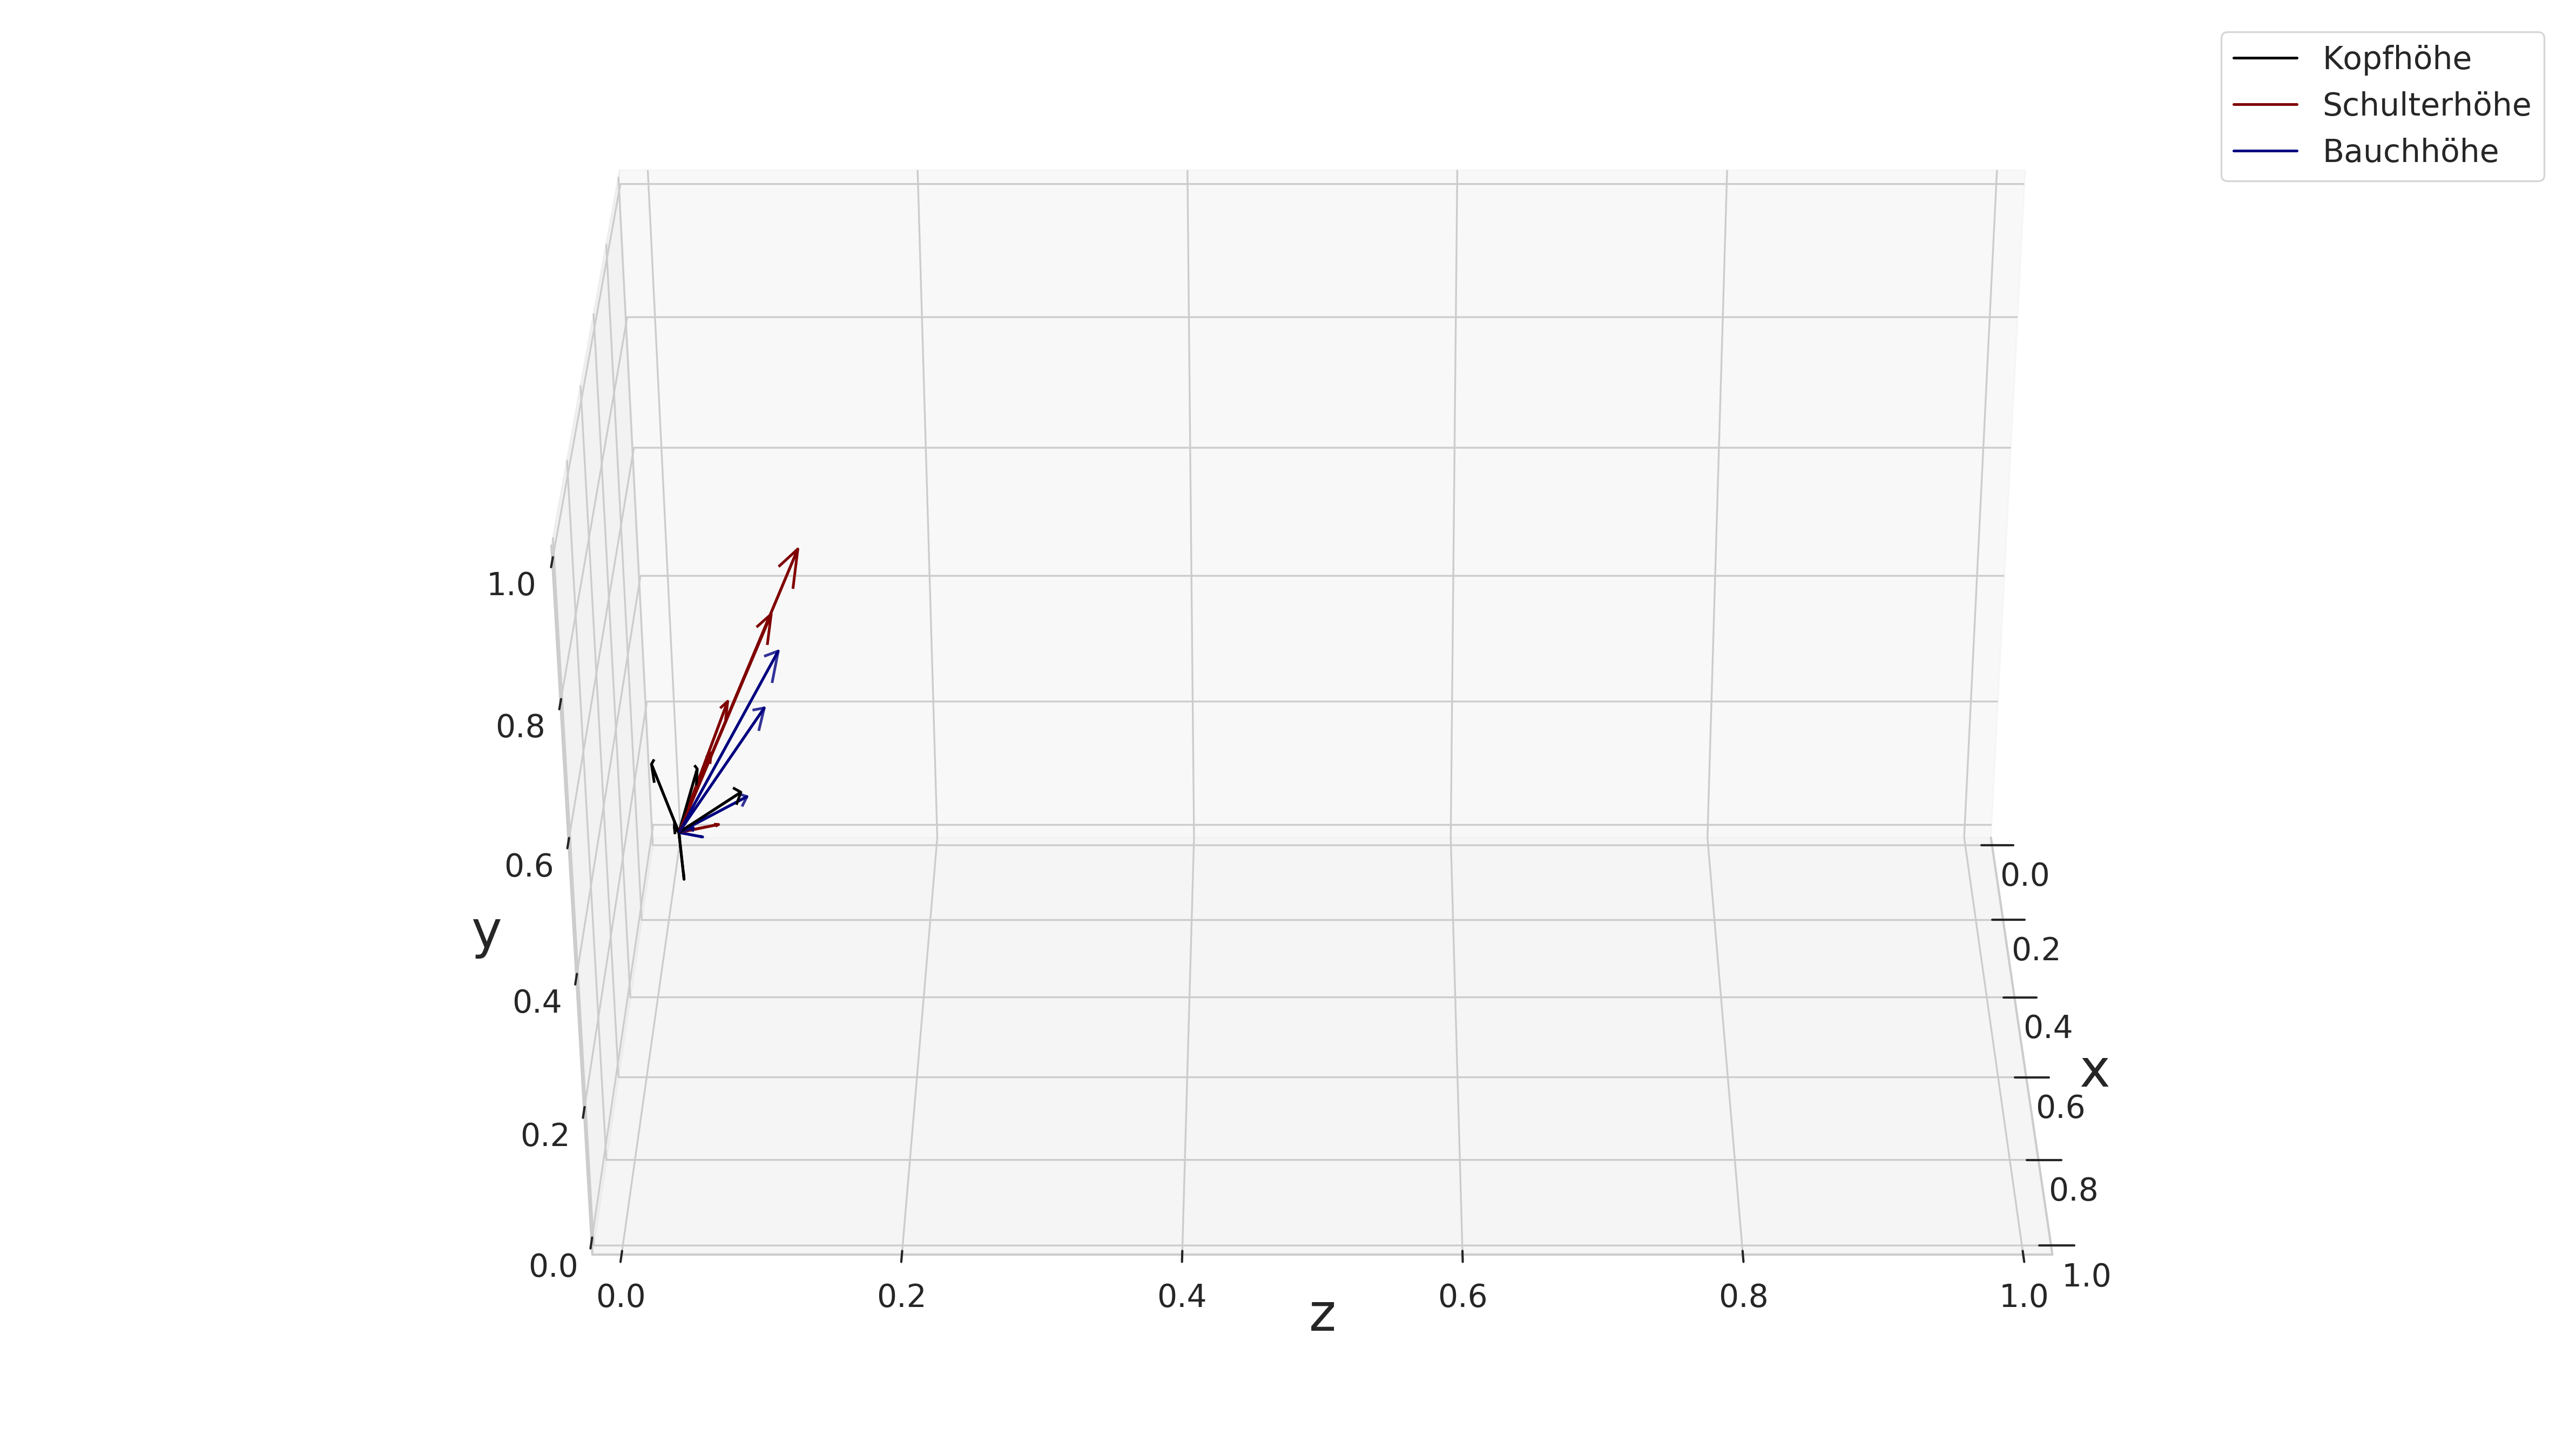

In [14]:
## PLOT FIRST SINGULAR VECTOR OF V
fig = plt.figure(figsize=(16,9))
# right hand

ax = fig.add_subplot(111, projection='3d')
counter = 0
for i in range(len(sv_r1)):
    if counter < 13:
        if counter == 0:
            c = palette1[2]
            c = 'black'
            label = 'hand; target r1'
        elif counter == 3:
            c = palette1[4]
            c = 'black'            
            label = 'wrist; target r1 '
        elif counter == 6:
            c = palette1[6]
            c = 'black'            
            label = 'lower arm; target r1'
        elif counter == 9:
            c = palette1[8]
            c = 'black'            
            label = 'upper arm; target r1'
        elif counter == 12:
            c = palette1[10]
            c = 'black'            
            label = 'shoulder; target r1'

        ax.plot(xs=(0,sv_r1[counter]), ys=(0,sv_r1[counter+2]), zs=(0,sv_r1[counter+1]), 
                color=c)
        ax.quiver(0,0, 0,sv_r1[counter],sv_r1[counter+2], sv_r1[counter+1], length = 1, arrow_length_ratio=0.1,
                color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(sv_r)):
    if counter < 13:
        if counter == 0:
            c = palette2[2]
            c = 'maroon'            
            label = 'hand; target r2'
        elif counter == 3:
            c = palette2[4]
            c = 'maroon'
            label = 'wrist; target r2'
        elif counter == 6:
            c = palette2[6]
            c = 'maroon'
            label = 'lower arm; target r2'
        elif counter == 9:
            c = palette2[8]
            c = 'maroon'            
            label = 'upper arm; target r2'
        elif counter == 12:
            c =palette2[10]
            c = 'maroon'            
            label = 'shoulder; target r2'

        ax.plot(xs=(0,sv_r2[counter]), ys=(0,sv_r2[counter+2]), zs=(0,sv_r2[counter+1]), 
                 color=c)
        ax.quiver(0,0, 0,sv_r2[counter],sv_r2[counter+2], sv_r2[counter+1], length = 1, arrow_length_ratio=0.1,
                  color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(sv_r)):
    if counter < 13:
        if counter == 0:
            c = palette3[2]
            c = 'navy'            
            label = 'hand; taregt r3'
        elif counter == 3:
            c = palette3[4]
            c = 'navy'
            label = 'wrist; taregt r3'
        elif counter == 6:
            c = palette3[6]
            c = 'navy'
            label = 'lower arm; taregt r3'
        elif counter == 9:
            c = palette3[8]
            c = 'navy'
            label = 'upper arm; taregt r3'
        elif counter == 12:
            c = palette3[10]
            c = 'navy'
            label = 'shoulder; taregt r3'

        ax.plot(xs=(0,sv_r3[counter]), ys=(0,sv_r3[counter+2]), zs=(0,sv_r3[counter+1]), 
                color=c, linestyle='-')
        ax.quiver(0,0, 0,sv_r3[counter],sv_r3[counter+2], sv_r3[counter+1], length = 1, arrow_length_ratio=0.1,
                  color=c, alpha=0.8, linestyle='-')
        print(counter)

    counter += 3

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)

ax.set_xlabel('x', fontsize=23)
ax.set_ylabel('z', fontsize=23)
ax.set_zlabel('y', fontsize=23)
ax.view_init(azim=0)
r1_line = mlines.Line2D([], [], color='Black', label='Kopfhöhe')
r2_line = mlines.Line2D([], [], color='maroon', label='Schulterhöhe')
r3_line = mlines.Line2D([], [], color='navy', label='Bauchhöhe')
plt.legend(handles=[r1_line, r2_line, r3_line])
plt.show()

0
3
6
9
12
0
3
6
9
12
0
3
6
9
12


/home/michael/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


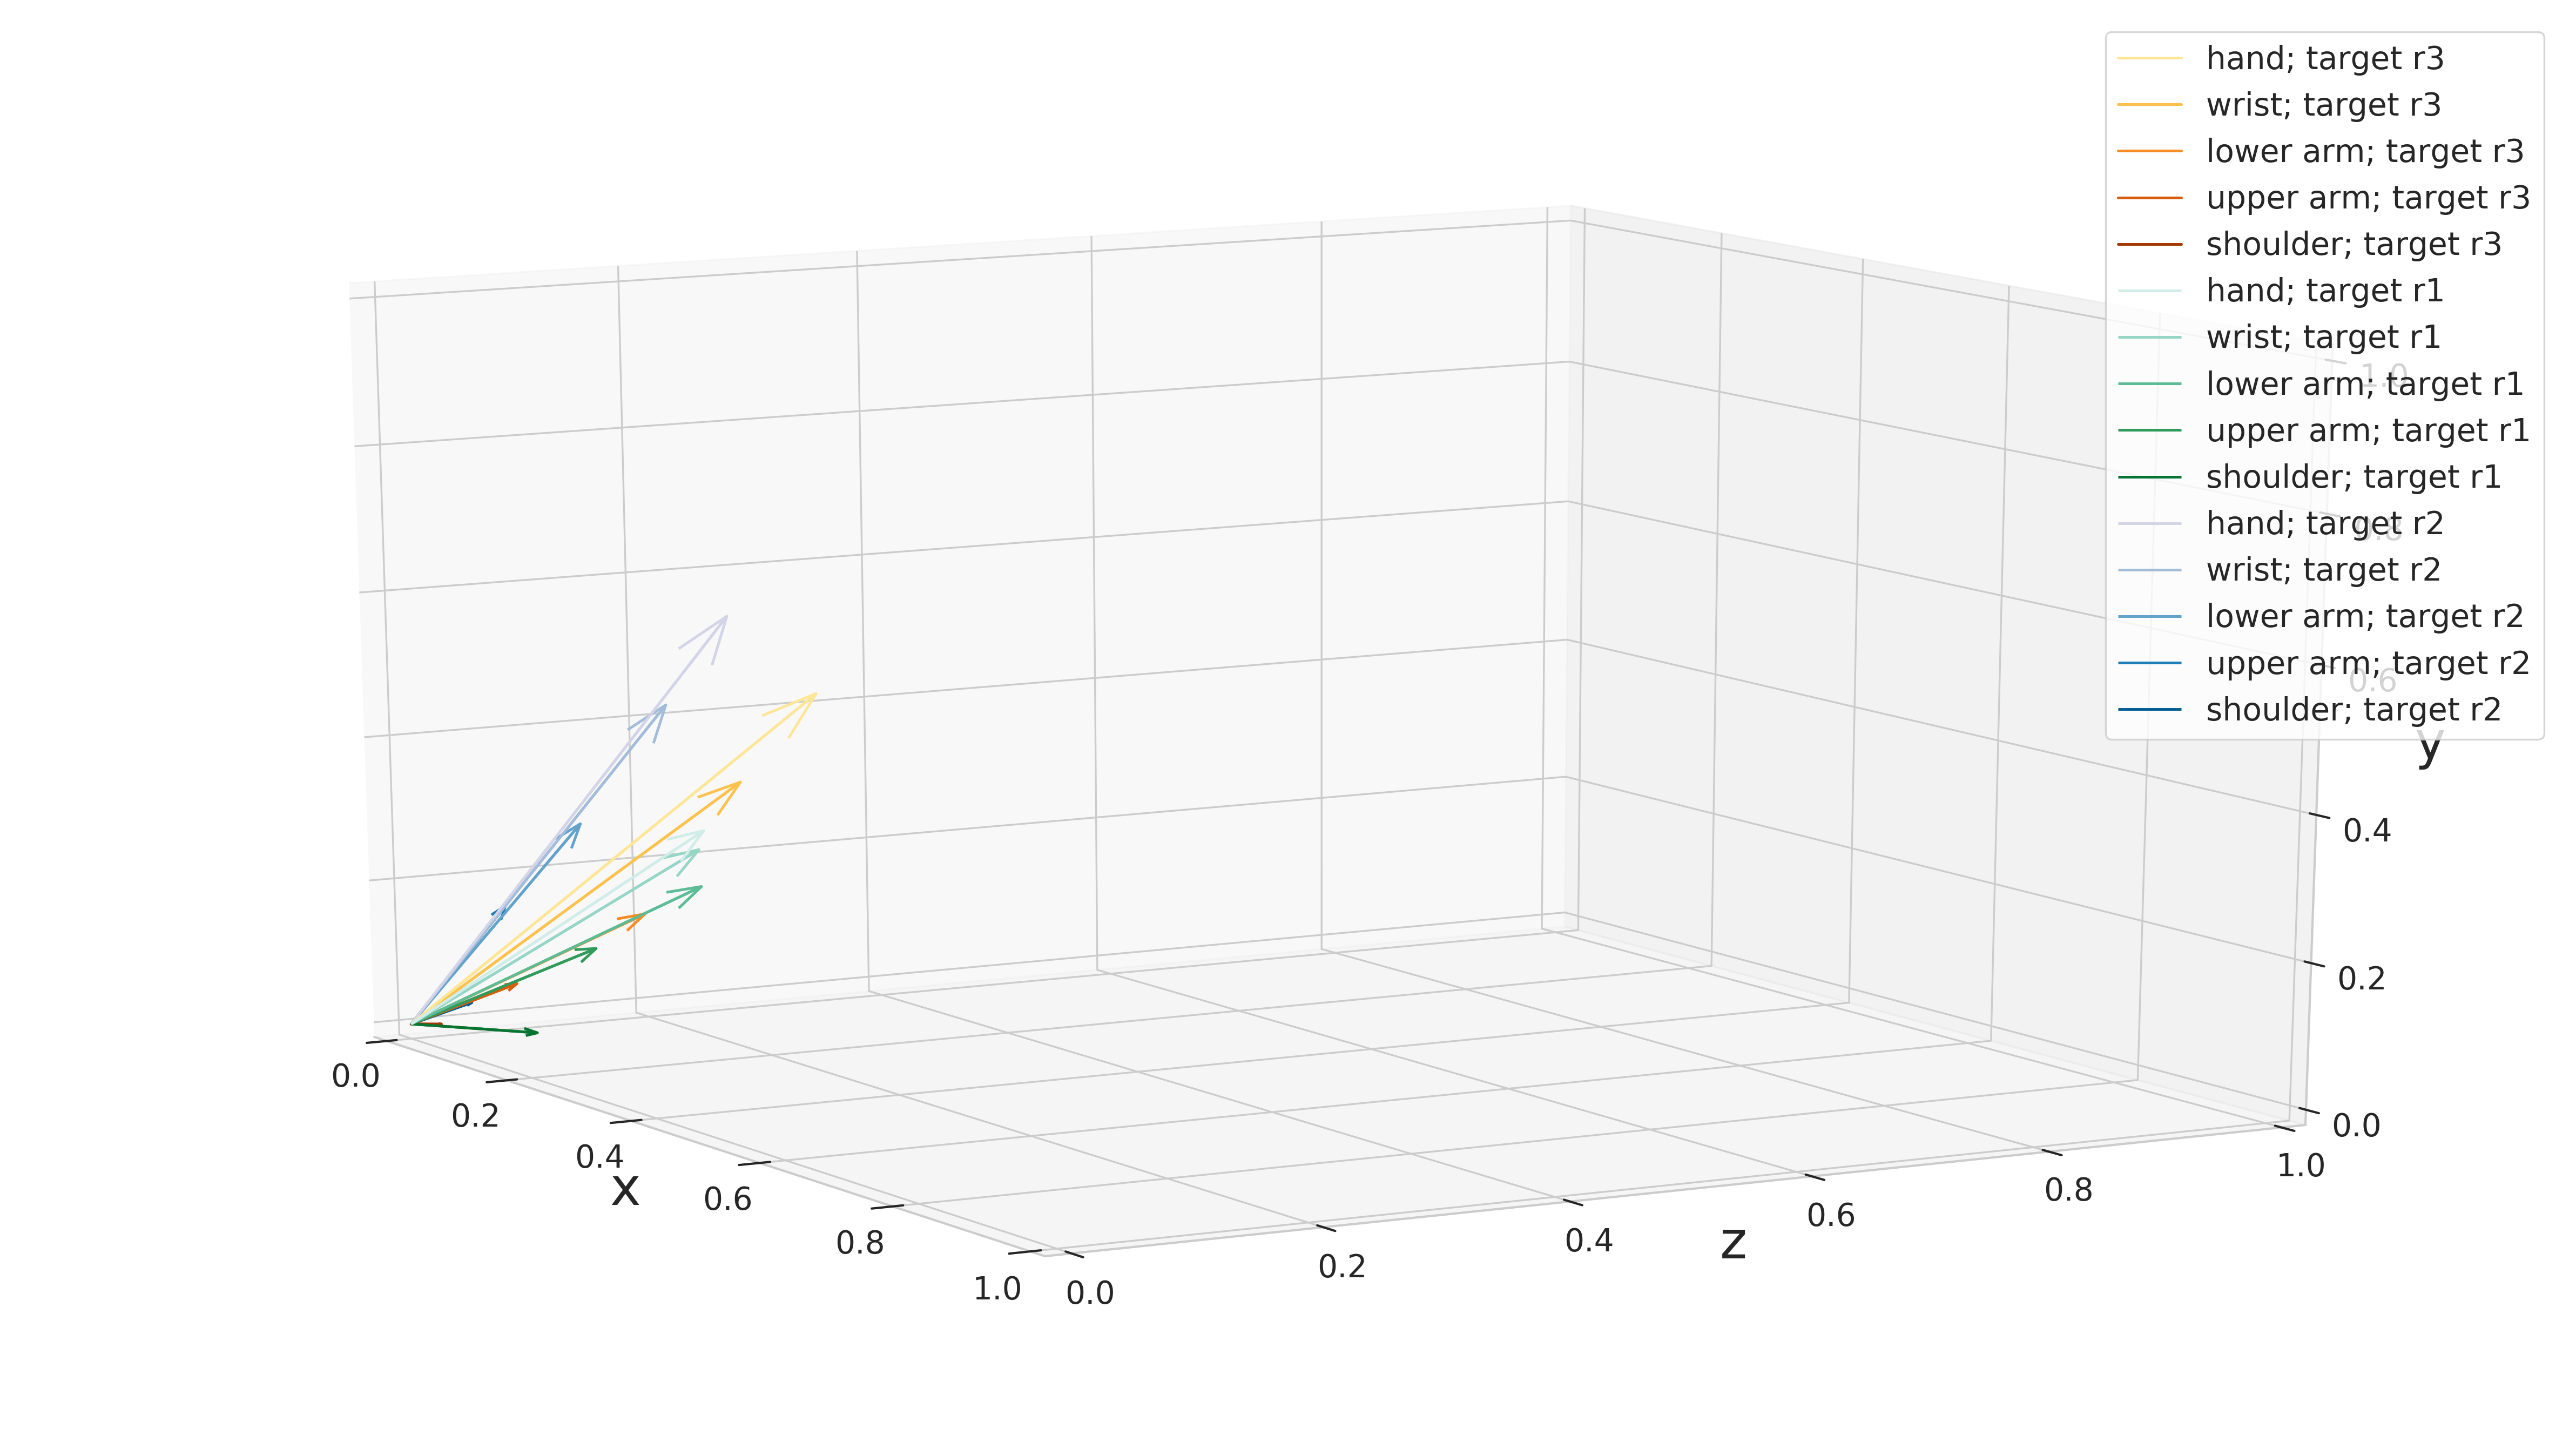

In [16]:
## PLOT FIRST SINGULAR VECTOR OF V
fig = plt.figure(figsize=(16,9))
# right hand

ax = fig.add_subplot(111, projection='3d')
counter = 0
for i in range(len(sv_r1)):
    if counter < 13:
        if counter == 0:
            c = palette1[2]
#             c = 'black'
            label = 'hand; target r1'
        elif counter == 3:
            c = palette1[4]
#             c = 'black'            
            label = 'wrist; target r1 '
        elif counter == 6:
            c = palette1[6]
#             c = 'black'            
            label = 'lower arm; target r1'
        elif counter == 9:
            c = palette1[8]
#             c = 'black'            
            label = 'upper arm; target r1'
        elif counter == 12:
            c = palette1[10]
#             c = 'black'            
            label = 'shoulder; target r1'

        ax.plot(xs=(0,sv_r1[counter]), ys=(0,sv_r1[counter+2]), zs=(0,sv_r1[counter+1]), 
                color=c)
        ax.quiver(0,0, 0,sv_r1[counter],sv_r1[counter+2], sv_r1[counter+1], length = 1, arrow_length_ratio=0.1,
                  label=label, color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(sv_r)):
    if counter < 13:
        if counter == 0:
            c = palette2[2]
#             c = 'maroon'            
            label = 'hand; target r2'
        elif counter == 3:
            c = palette2[4]
#             c = 'maroon'
            label = 'wrist; target r2'
        elif counter == 6:
            c = palette2[6]
#             c = 'maroon'
            label = 'lower arm; target r2'
        elif counter == 9:
            c = palette2[8]
#             c = 'maroon'            
            label = 'upper arm; target r2'
        elif counter == 12:
            c =palette2[10]
#             c = 'maroon'            
            label = 'shoulder; target r2'

        ax.plot(xs=(0,sv_r2[counter]), ys=(0,sv_r2[counter+2]), zs=(0,sv_r2[counter+1]), 
                 color=c)
        ax.quiver(0,0, 0,sv_r2[counter],sv_r2[counter+2], sv_r2[counter+1], length = 1, arrow_length_ratio=0.1,
                  label=label, color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(sv_r)):
    if counter < 13:
        if counter == 0:
            c = palette3[2]
#             c = 'navy'            
            label = 'hand; target r3'
        elif counter == 3:
            c = palette3[4]
#             c = 'navy'
            label = 'wrist; target r3'
        elif counter == 6:
            c = palette3[6]
#             c = 'navy'
            label = 'lower arm; target r3'
        elif counter == 9:
            c = palette3[8]
#             c = 'navy'
            label = 'upper arm; target r3'
        elif counter == 12:
            c = palette3[10]
#             c = 'navy'
            label = 'shoulder; target r3'

        ax.plot(xs=(0,sv_r3[counter]), ys=(0,sv_r3[counter+2]), zs=(0,sv_r3[counter+1]), 
                color=c, label=label, linestyle='-')
        ax.quiver(0,0, 0,sv_r3[counter],sv_r3[counter+2], sv_r3[counter+1], length = 1, arrow_length_ratio=0.1,
                  color=c)
        print(counter)

    counter += 3



ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)



ax.set_xlabel('x', fontsize=23)
ax.set_ylabel('z', fontsize=23)
ax.set_zlabel('y', fontsize=23)
ax.view_init(azim=310)
plt.legend()

try:
    os.makedirs('/home/michael/view/r/'+subj+'/')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
    # get DATA

for deg in range(0,360,30):
    ax.view_init(elev=15., azim=deg)
    plt.savefig('/home/michael/view/r/{a}/{a}_r_{b}d.png'.format(a=subj, b=deg))
# plt.show()

0
3
6
9
12
0
3
6
9
12
0
3
6
9
12


/home/michael/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


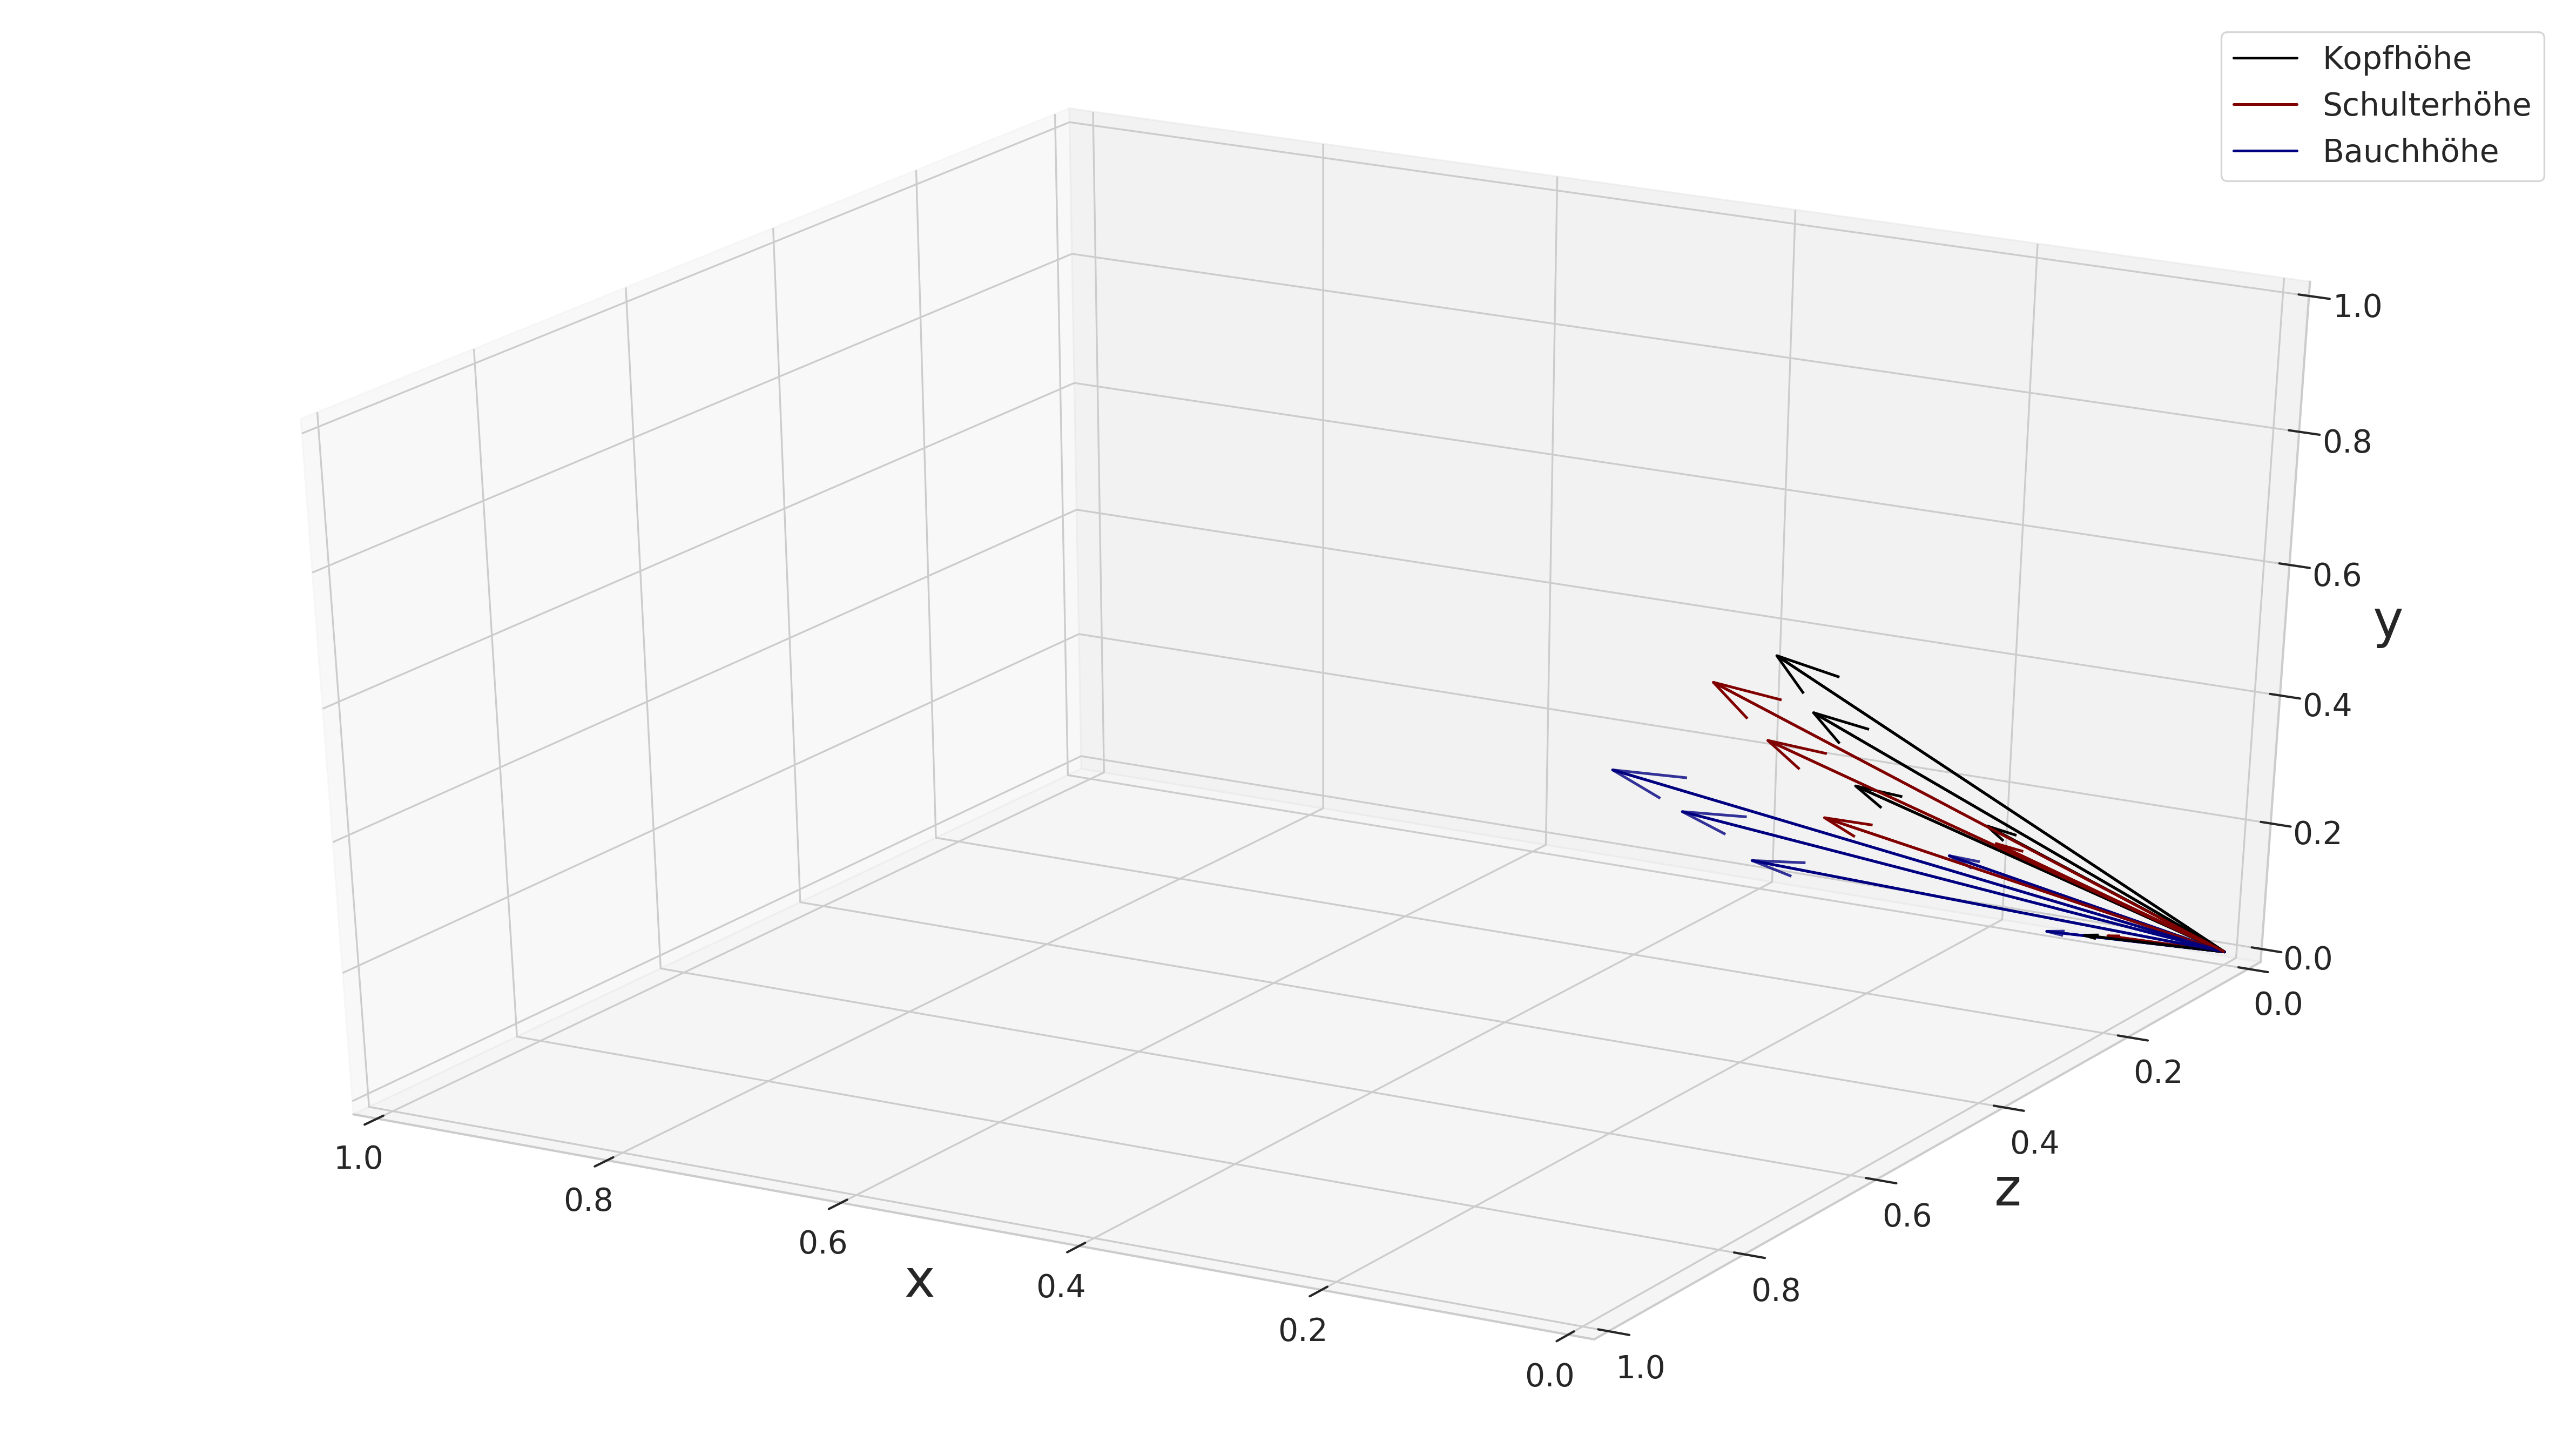

In [17]:
## PLOT FIRST SINGULAR VECTOR OF V
fig = plt.figure(figsize=(16,9))
# right hand

ax = fig.add_subplot(111, projection='3d')
counter = 0
for i in range(len(sv_r1)):
    if counter < 13:
        if counter == 0:
            c = palette1[2]
            c = 'black'
            label = 'hand; target l1'
        elif counter == 3:
            c = palette1[4]
            c = 'black'            
            label = 'wrist; target l1 '
        elif counter == 6:
            c = palette1[6]
            c = 'black'            
            label = 'lower arm; target l1'
        elif counter == 9:
            c = palette1[8]
            c = 'black'            
            label = 'upper arm; target l1'
        elif counter == 12:
            c = palette1[10]
            c = 'black'            
            label = 'shoulder; target l1'

        ax.plot(xs=(0,sv_l1[counter]), ys=(0,sv_l1[counter+2]), zs=(0,sv_l1[counter+1]), 
                color=c)
        ax.quiver(0,0, 0,sv_l1[counter],sv_l1[counter+2], sv_l1[counter+1], length = 1, arrow_length_ratio=0.1,
                  color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(sv_r)):
    if counter < 13:
        if counter == 0:
            c = palette2[2]
            c = 'maroon'            
            label = 'hand; target l2'
        elif counter == 3:
            c = palette2[4]
            c = 'maroon'
            label = 'wrist; target l2'
        elif counter == 6:
            c = palette2[6]
            c = 'maroon'
            label = 'lower arm; target l2'
        elif counter == 9:
            c = palette2[8]
            c = 'maroon'            
            label = 'upper arm; target l2'
        elif counter == 12:
            c =palette2[10]
            c = 'maroon'            
            label = 'shoulder; target l2'

        ax.plot(xs=(0,sv_l2[counter]), ys=(0,sv_l2[counter+2]), zs=(0,sv_l2[counter+1]), 
                 color=c)
        ax.quiver(0,0, 0,sv_l2[counter],sv_l2[counter+2], sv_l2[counter+1], length = 1, arrow_length_ratio=0.1,
                  color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(sv_r)):
    if counter < 13:
        if counter == 0:
            c = palette3[2]
            c = 'navy'            
            label = 'hand; taregt l3'
        elif counter == 3:
            c = palette3[4]
            c = 'navy'
            label = 'wrist; taregt l3'
        elif counter == 6:
            c = palette3[6]
            c = 'navy'
            label = 'lower arm; taregt l3'
        elif counter == 9:
            c = palette3[8]
            c = 'navy'
            label = 'upper arm; taregt l3'
        elif counter == 12:
            c = palette3[10]
            c = 'navy'
            label = 'shoulder; taregt l3'

        ax.plot(xs=(0,sv_l3[counter]), ys=(0,sv_l3[counter+2]), zs=(0,sv_l3[counter+1]), 
                color=c, linestyle='-')
        ax.quiver(0,0, 0,sv_l3[counter],sv_l3[counter+2], sv_l3[counter+1], length = 1, arrow_length_ratio=0.1,
                  color=c, alpha=0.8, linestyle='-')
        print(counter)

    counter += 3



ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)



ax.set_xlabel('x', fontsize=23)
ax.set_ylabel('z', fontsize=23)
ax.set_zlabel('y', fontsize=23)
ax.view_init(azim=120)
r1_line = mlines.Line2D([], [], color='Black', label='Kopfhöhe')
r2_line = mlines.Line2D([], [], color='maroon', label='Schulterhöhe')
r3_line = mlines.Line2D([], [], color='navy', label='Bauchhöhe')
plt.legend(handles=[r1_line, r2_line, r3_line])



plt.show()

0
3
6
9
12
0
3
6
9
12
0
3
6
9
12


/home/michael/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


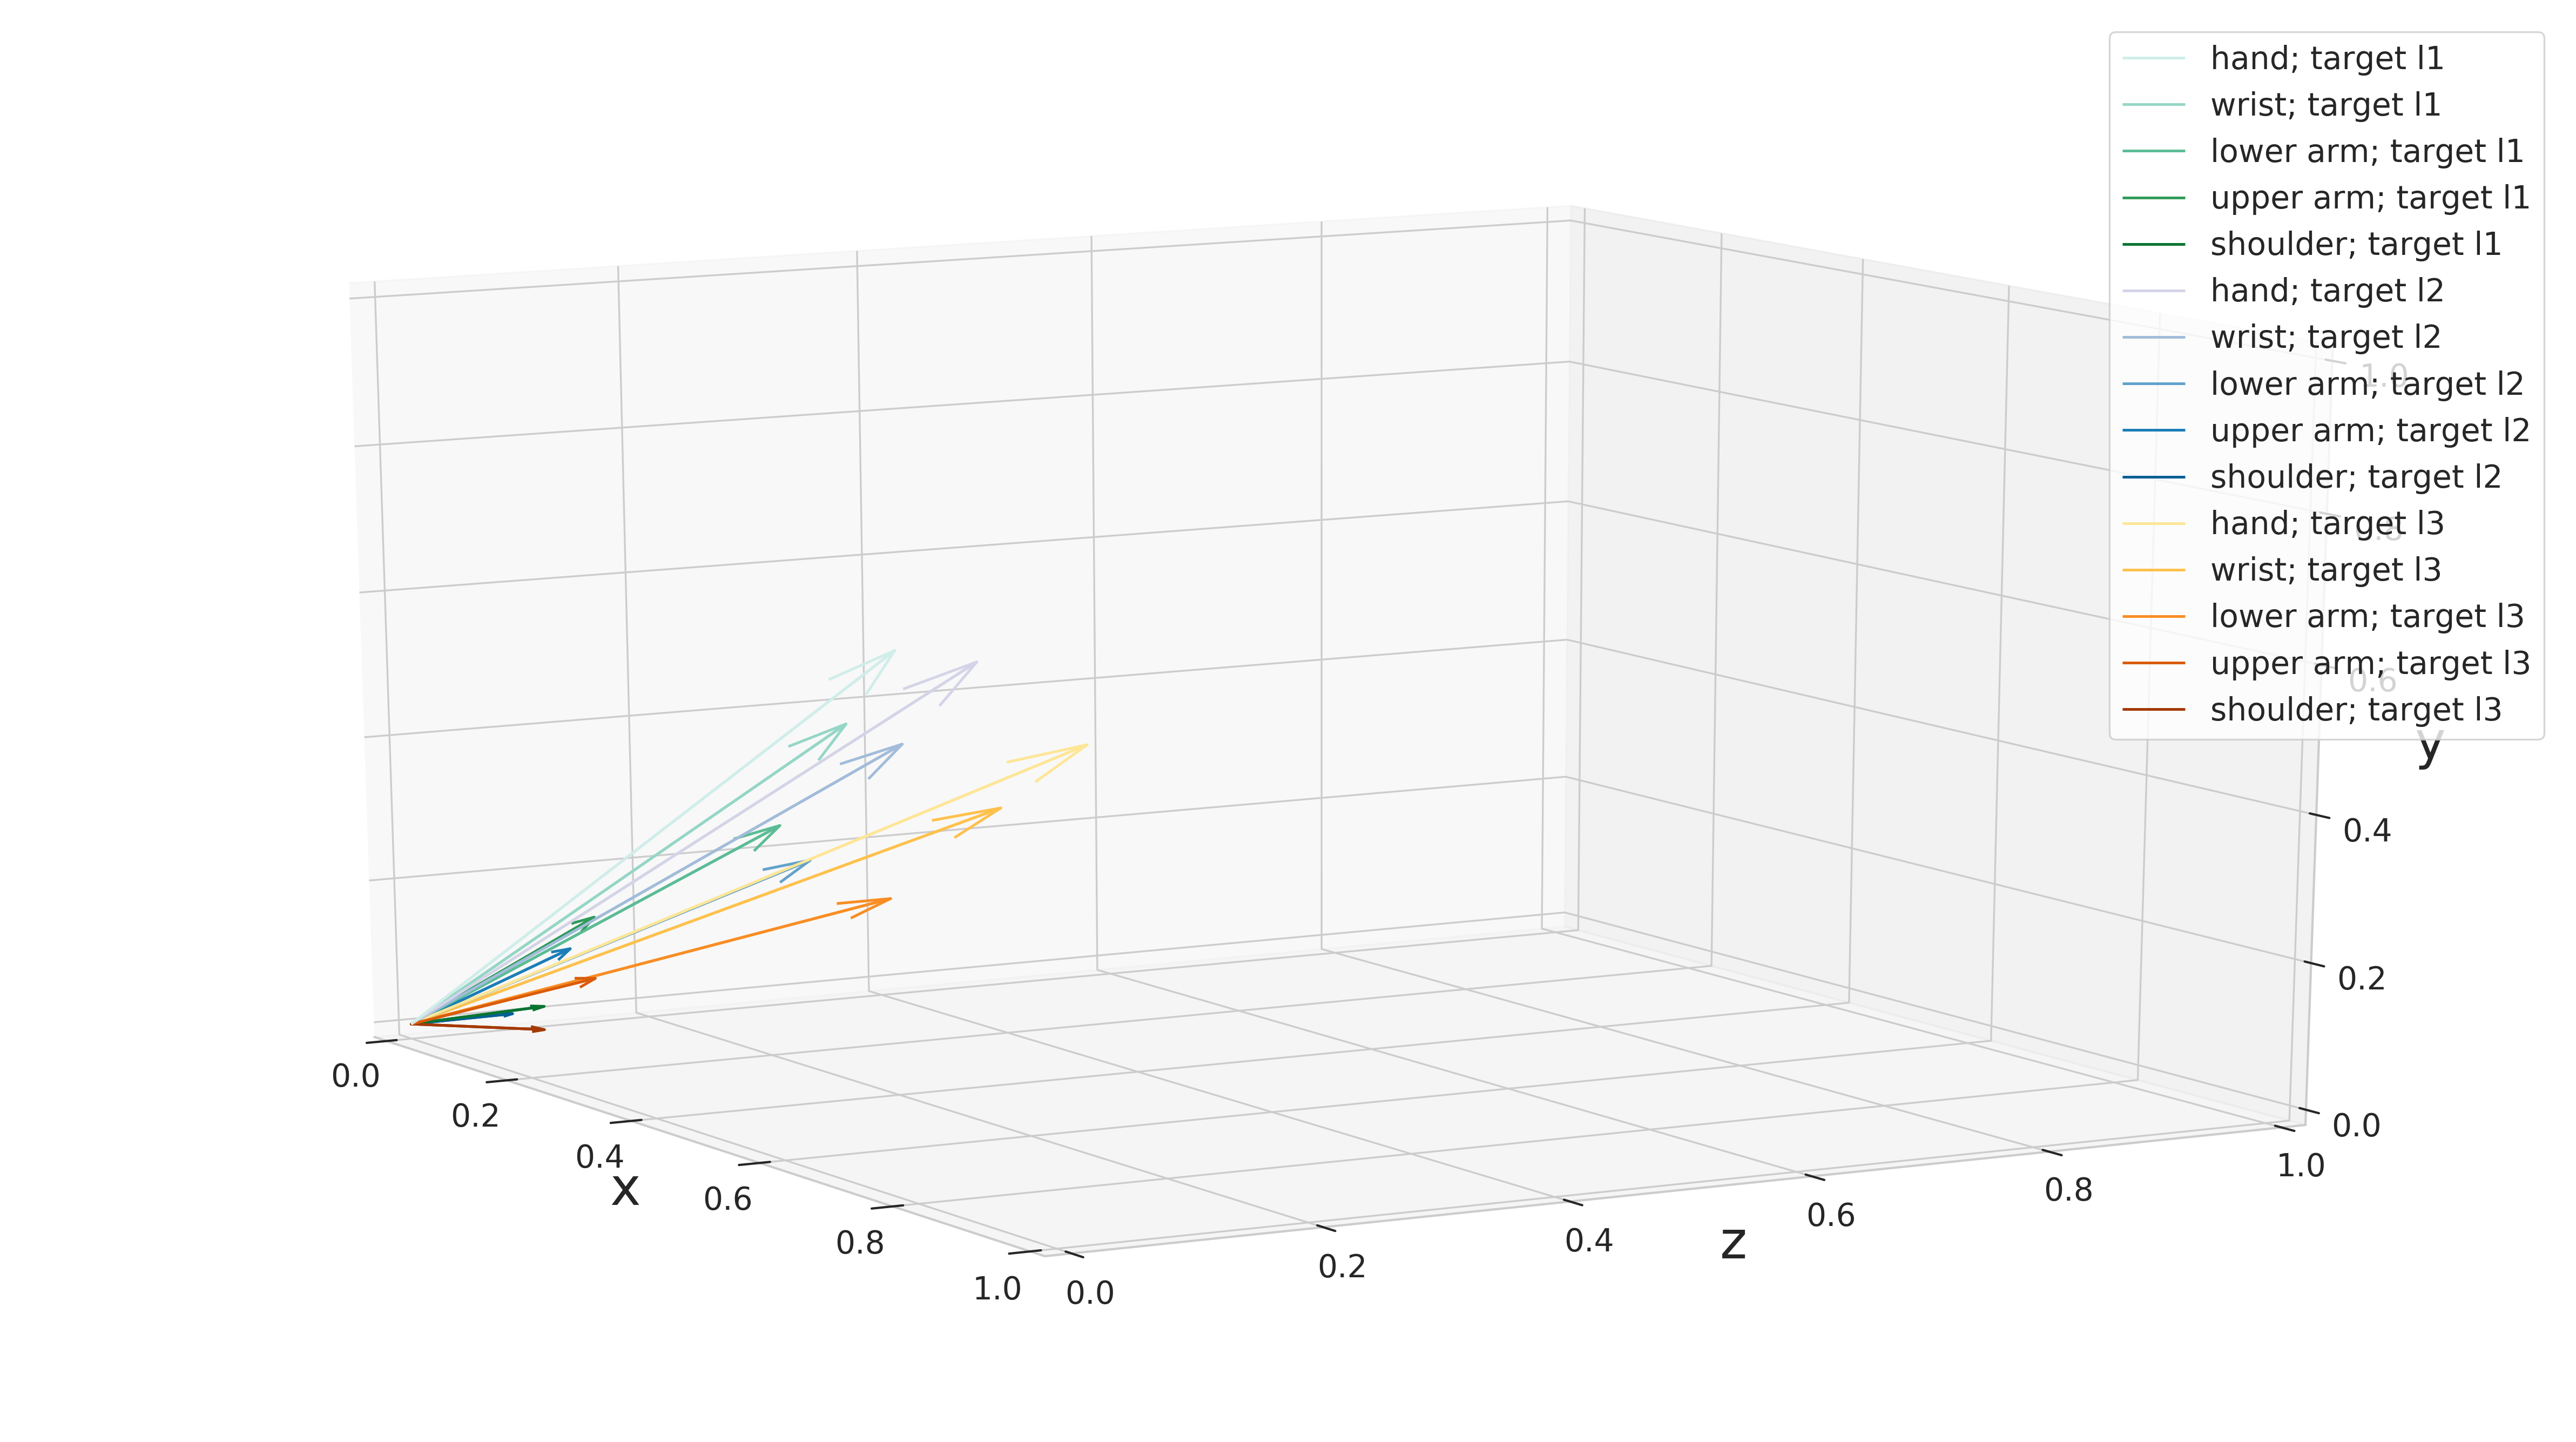

In [18]:
## PLOT FIRST SINGULAR VECTOR OF V
fig = plt.figure(figsize=(16,9))
# right hand

ax = fig.add_subplot(111, projection='3d')
counter = 0
for i in range(len(sv_r1)):
    if counter < 13:
        if counter == 0:
            c = palette1[2]
#             c = 'black'
            label = 'hand; target l1'
        elif counter == 3:
            c = palette1[4]
#             c = 'black'            
            label = 'wrist; target l1'
        elif counter == 6:
            c = palette1[6]
#             c = 'black'            
            label = 'lower arm; target l1'
        elif counter == 9:
            c = palette1[8]
#             c = 'black'            
            label = 'upper arm; target l1'
        elif counter == 12:
            c = palette1[10]
#             c = 'black'            
            label = 'shoulder; target l1'

        ax.plot(xs=(0,sv_l1[counter]), ys=(0,sv_l1[counter+2]), zs=(0,sv_l1[counter+1]), 
                color=c)
        ax.quiver(0,0, 0,sv_l1[counter],sv_l1[counter+2], sv_l1[counter+1], length = 1, arrow_length_ratio=0.1,
                  label=label, color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(sv_r)):
    if counter < 13:
        if counter == 0:
            c = palette2[2]
#             c = 'maroon'            
            label = 'hand; target l2'
        elif counter == 3:
            c = palette2[4]
#             c = 'maroon'
            label = 'wrist; target l2'
        elif counter == 6:
            c = palette2[6]
#             c = 'maroon'
            label = 'lower arm; target l2'
        elif counter == 9:
            c = palette2[8]
#             c = 'maroon'            
            label = 'upper arm; target l2'
        elif counter == 12:
            c =palette2[10]
#             c = 'maroon'            
            label = 'shoulder; target l2'

        ax.plot(xs=(0,sv_l2[counter]), ys=(0,sv_l2[counter+2]), zs=(0,sv_l2[counter+1]), 
                 color=c)
        ax.quiver(0,0, 0,sv_l2[counter],sv_l2[counter+2], sv_l2[counter+1], length = 1, arrow_length_ratio=0.1,
                  label=label, color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(sv_r)):
    if counter < 13:
        if counter == 0:
            c = palette3[2]
#             c = 'navy'            
            label = 'hand; target l3'
        elif counter == 3:
            c = palette3[4]
#             c = 'navy'
            label = 'wrist; target l3'
        elif counter == 6:
            c = palette3[6]
#             c = 'navy'
            label = 'lower arm; target l3'
        elif counter == 9:
            c = palette3[8]
#             c = 'navy'
            label = 'upper arm; target l3'
        elif counter == 12:
            c = palette3[10]
#             c = 'navy'
            label = 'shoulder; target l3'

        ax.plot(xs=(0,sv_l3[counter]), ys=(0,sv_l3[counter+2]), zs=(0,sv_l3[counter+1]), 
                color=c, linestyle='-')
        ax.quiver(0,0, 0,sv_l3[counter],sv_l3[counter+2], sv_l3[counter+1], length = 1, arrow_length_ratio=0.1,
                  label=label, color=c)
        print(counter)

    counter += 3



ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)


ax.set_xlabel('x', fontsize=23)
ax.set_ylabel('z', fontsize=23)
ax.set_zlabel('y', fontsize=23)
ax.view_init(azim=150)
# r1_line = mlines.Line2D([], [], color='Black', label='Kopfhöhe')
# r2_line = mlines.Line2D([], [], color='maroon', label='Schulterhöhe')
# r3_line = mlines.Line2D([], [], color='navy', label='Bauchhöhe')
# plt.legend(handles=[r1_line, r2_line, r3_line])
plt.legend()

try:
    os.makedirs('/home/michael/view/l/'+subj+'/')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
    # get DATA

for deg in range(0,360,30):
    ax.view_init(elev=15., azim=deg)
    plt.savefig('/home/michael/view/l/{a}/{a}_l_{b}d.png'.format(a=subj, b=deg))

plt.show()

0
3
6
9
12
0
3
6
9
12
0
3
6
9
12


/home/michael/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


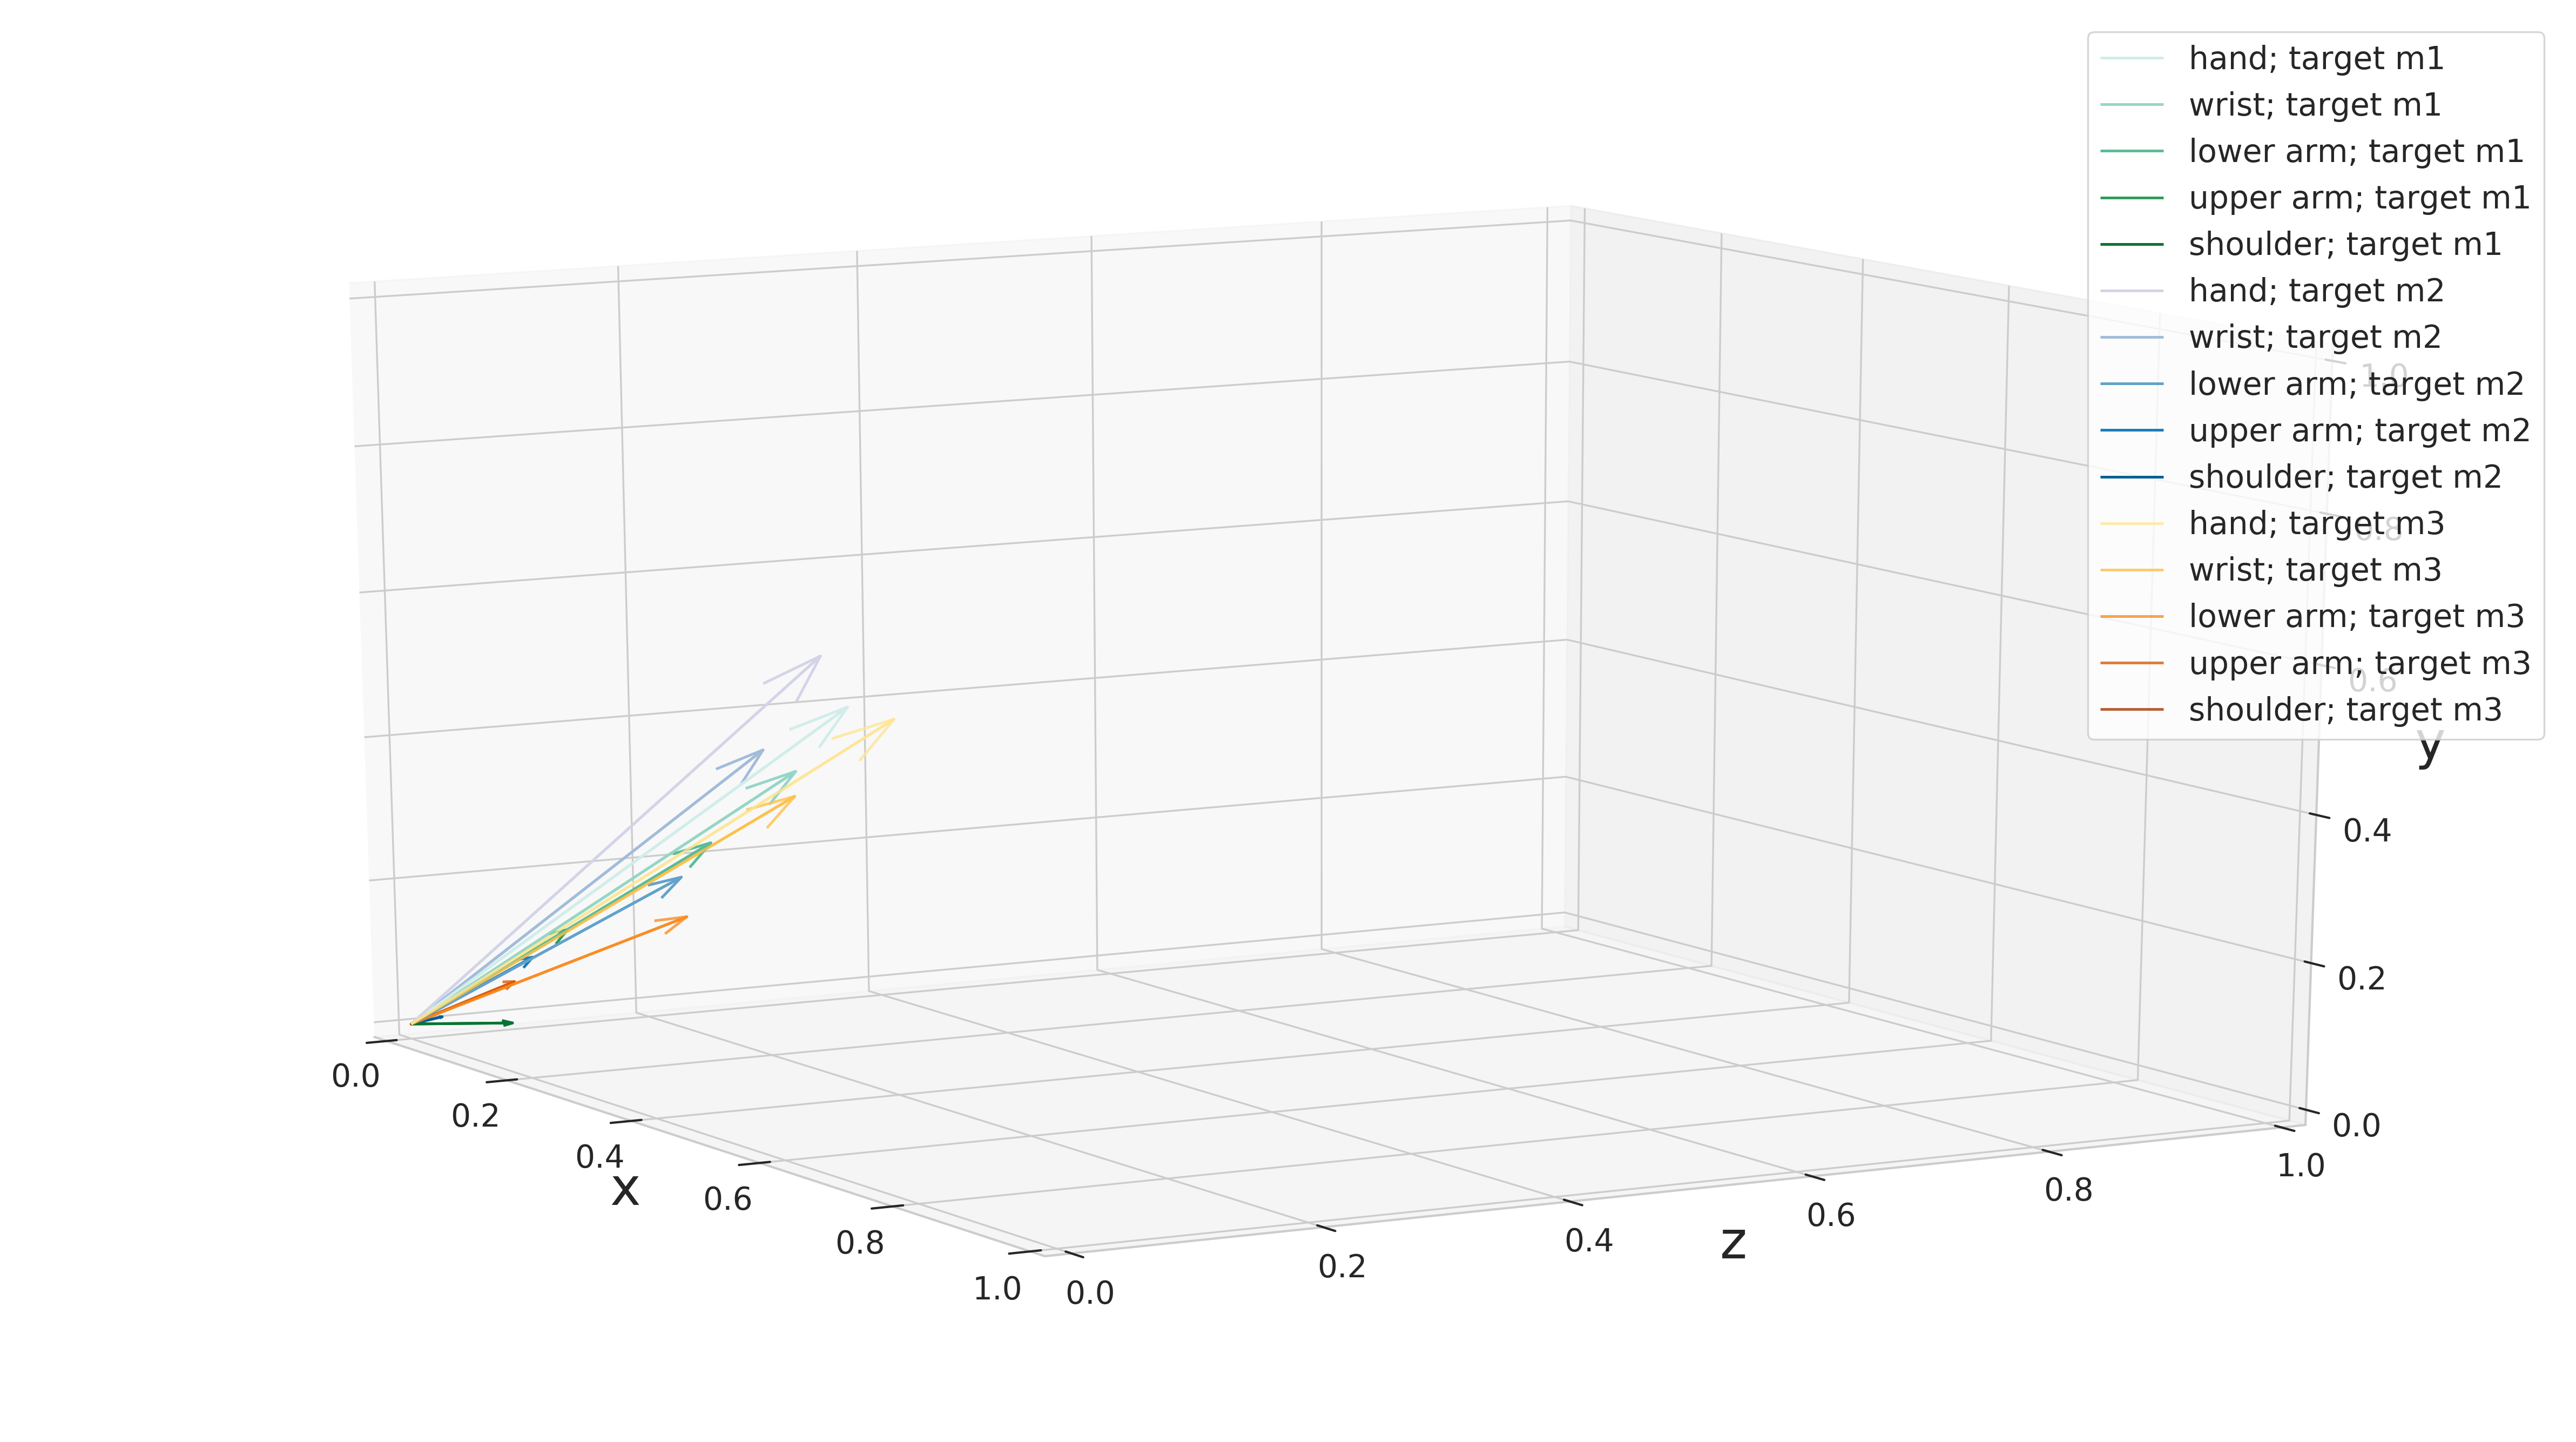

In [19]:
## PLOT FIRST SINGULAR VECTOR OF V
fig = plt.figure(figsize=(16,9))
# right hand

ax = fig.add_subplot(111, projection='3d')
counter = 0
for i in range(len(sv_r1)):
    if counter < 13:
        if counter == 0:
            c = palette1[2]
#             c = 'black'
            label = 'hand; target m1'
        elif counter == 3:
            c = palette1[4]
#             c = 'black'            
            label = 'wrist; target m1'
        elif counter == 6:
            c = palette1[6]
#             c = 'black'            
            label = 'lower arm; target m1'
        elif counter == 9:
            c = palette1[8]
#             c = 'black'            
            label = 'upper arm; target m1'
        elif counter == 12:
            c = palette1[10]
#             c = 'black'            
            label = 'shoulder; target m1'

        ax.plot(xs=(0,sv_m1[counter]), ys=(0,sv_m1[counter+2]), zs=(0,sv_m1[counter+1]), 
                color=c)
        ax.quiver(0,0, 0,sv_m1[counter],sv_m1[counter+2], sv_m1[counter+1], length = 1, arrow_length_ratio=0.1,
                  label=label, color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(sv_r)):
    if counter < 13:
        if counter == 0:
            c = palette2[2]
#             c = 'maroon'            
            label = 'hand; target m2'
        elif counter == 3:
            c = palette2[4]
#             c = 'maroon'
            label = 'wrist; target m2'
        elif counter == 6:
            c = palette2[6]
#             c = 'maroon'
            label = 'lower arm; target m2'
        elif counter == 9:
            c = palette2[8]
#             c = 'maroon'            
            label = 'upper arm; target m2'
        elif counter == 12:
            c =palette2[10]
#             c = 'maroon'            
            label = 'shoulder; target m2'

        ax.plot(xs=(0,sv_m2[counter]), ys=(0,sv_m2[counter+2]), zs=(0,sv_m2[counter+1]), 
                 color=c)
        ax.quiver(0,0, 0,sv_m2[counter],sv_m2[counter+2], sv_m2[counter+1], length = 1, arrow_length_ratio=0.1,
                  label=label, color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(sv_r)):
    if counter < 13:
        if counter == 0:
            c = palette3[2]
#             c = 'navy'            
            label = 'hand; target m3'
        elif counter == 3:
            c = palette3[4]
#             c = 'navy'
            label = 'wrist; target m3'
        elif counter == 6:
            c = palette3[6]
#             c = 'navy'
            label = 'lower arm; target m3'
        elif counter == 9:
            c = palette3[8]
#             c = 'navy'
            label = 'upper arm; target m3'
        elif counter == 12:
            c = palette3[10]
#             c = 'navy'
            label = 'shoulder; target m3'

        ax.plot(xs=(0,sv_m3[counter]), ys=(0,sv_m3[counter+2]), zs=(0,sv_m3[counter+1]), 
                color=c, linestyle='-')
        ax.quiver(0,0, 0,sv_m3[counter],sv_m3[counter+2], sv_m3[counter+1], length = 1, arrow_length_ratio=0.1,
                  label=label, color=c, alpha=0.8, linestyle='-')
        print(counter)

    counter += 3



ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)


ax.set_xlabel('x', fontsize=23)
ax.set_ylabel('z', fontsize=23)
ax.set_zlabel('y', fontsize=23)
ax.view_init(azim=0)
# r1_line = mlines.Line2D([], [], color='Black', label='Kopfhöhe')
# r2_line = mlines.Line2D([], [], color='maroon', label='Schulterhöhe')
# r3_line = mlines.Line2D([], [], color='navy', label='Bauchhöhe')
# plt.legend(handles=[r1_line, r2_line, r3_line])
plt.legend()

try:
    os.makedirs('/home/michael/view/m/'+subj+'/')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
    # get DATA

for deg in range(0,360,30):
    ax.view_init(elev=15., azim=deg)
    plt.savefig('/home/michael/view/m/{a}/{a}_m_{b}d.png'.format(a=subj, b=deg))
    
plt.show()

0
3
6
9
12
0
3
6
9
12
0
3
6
9
12


/home/michael/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


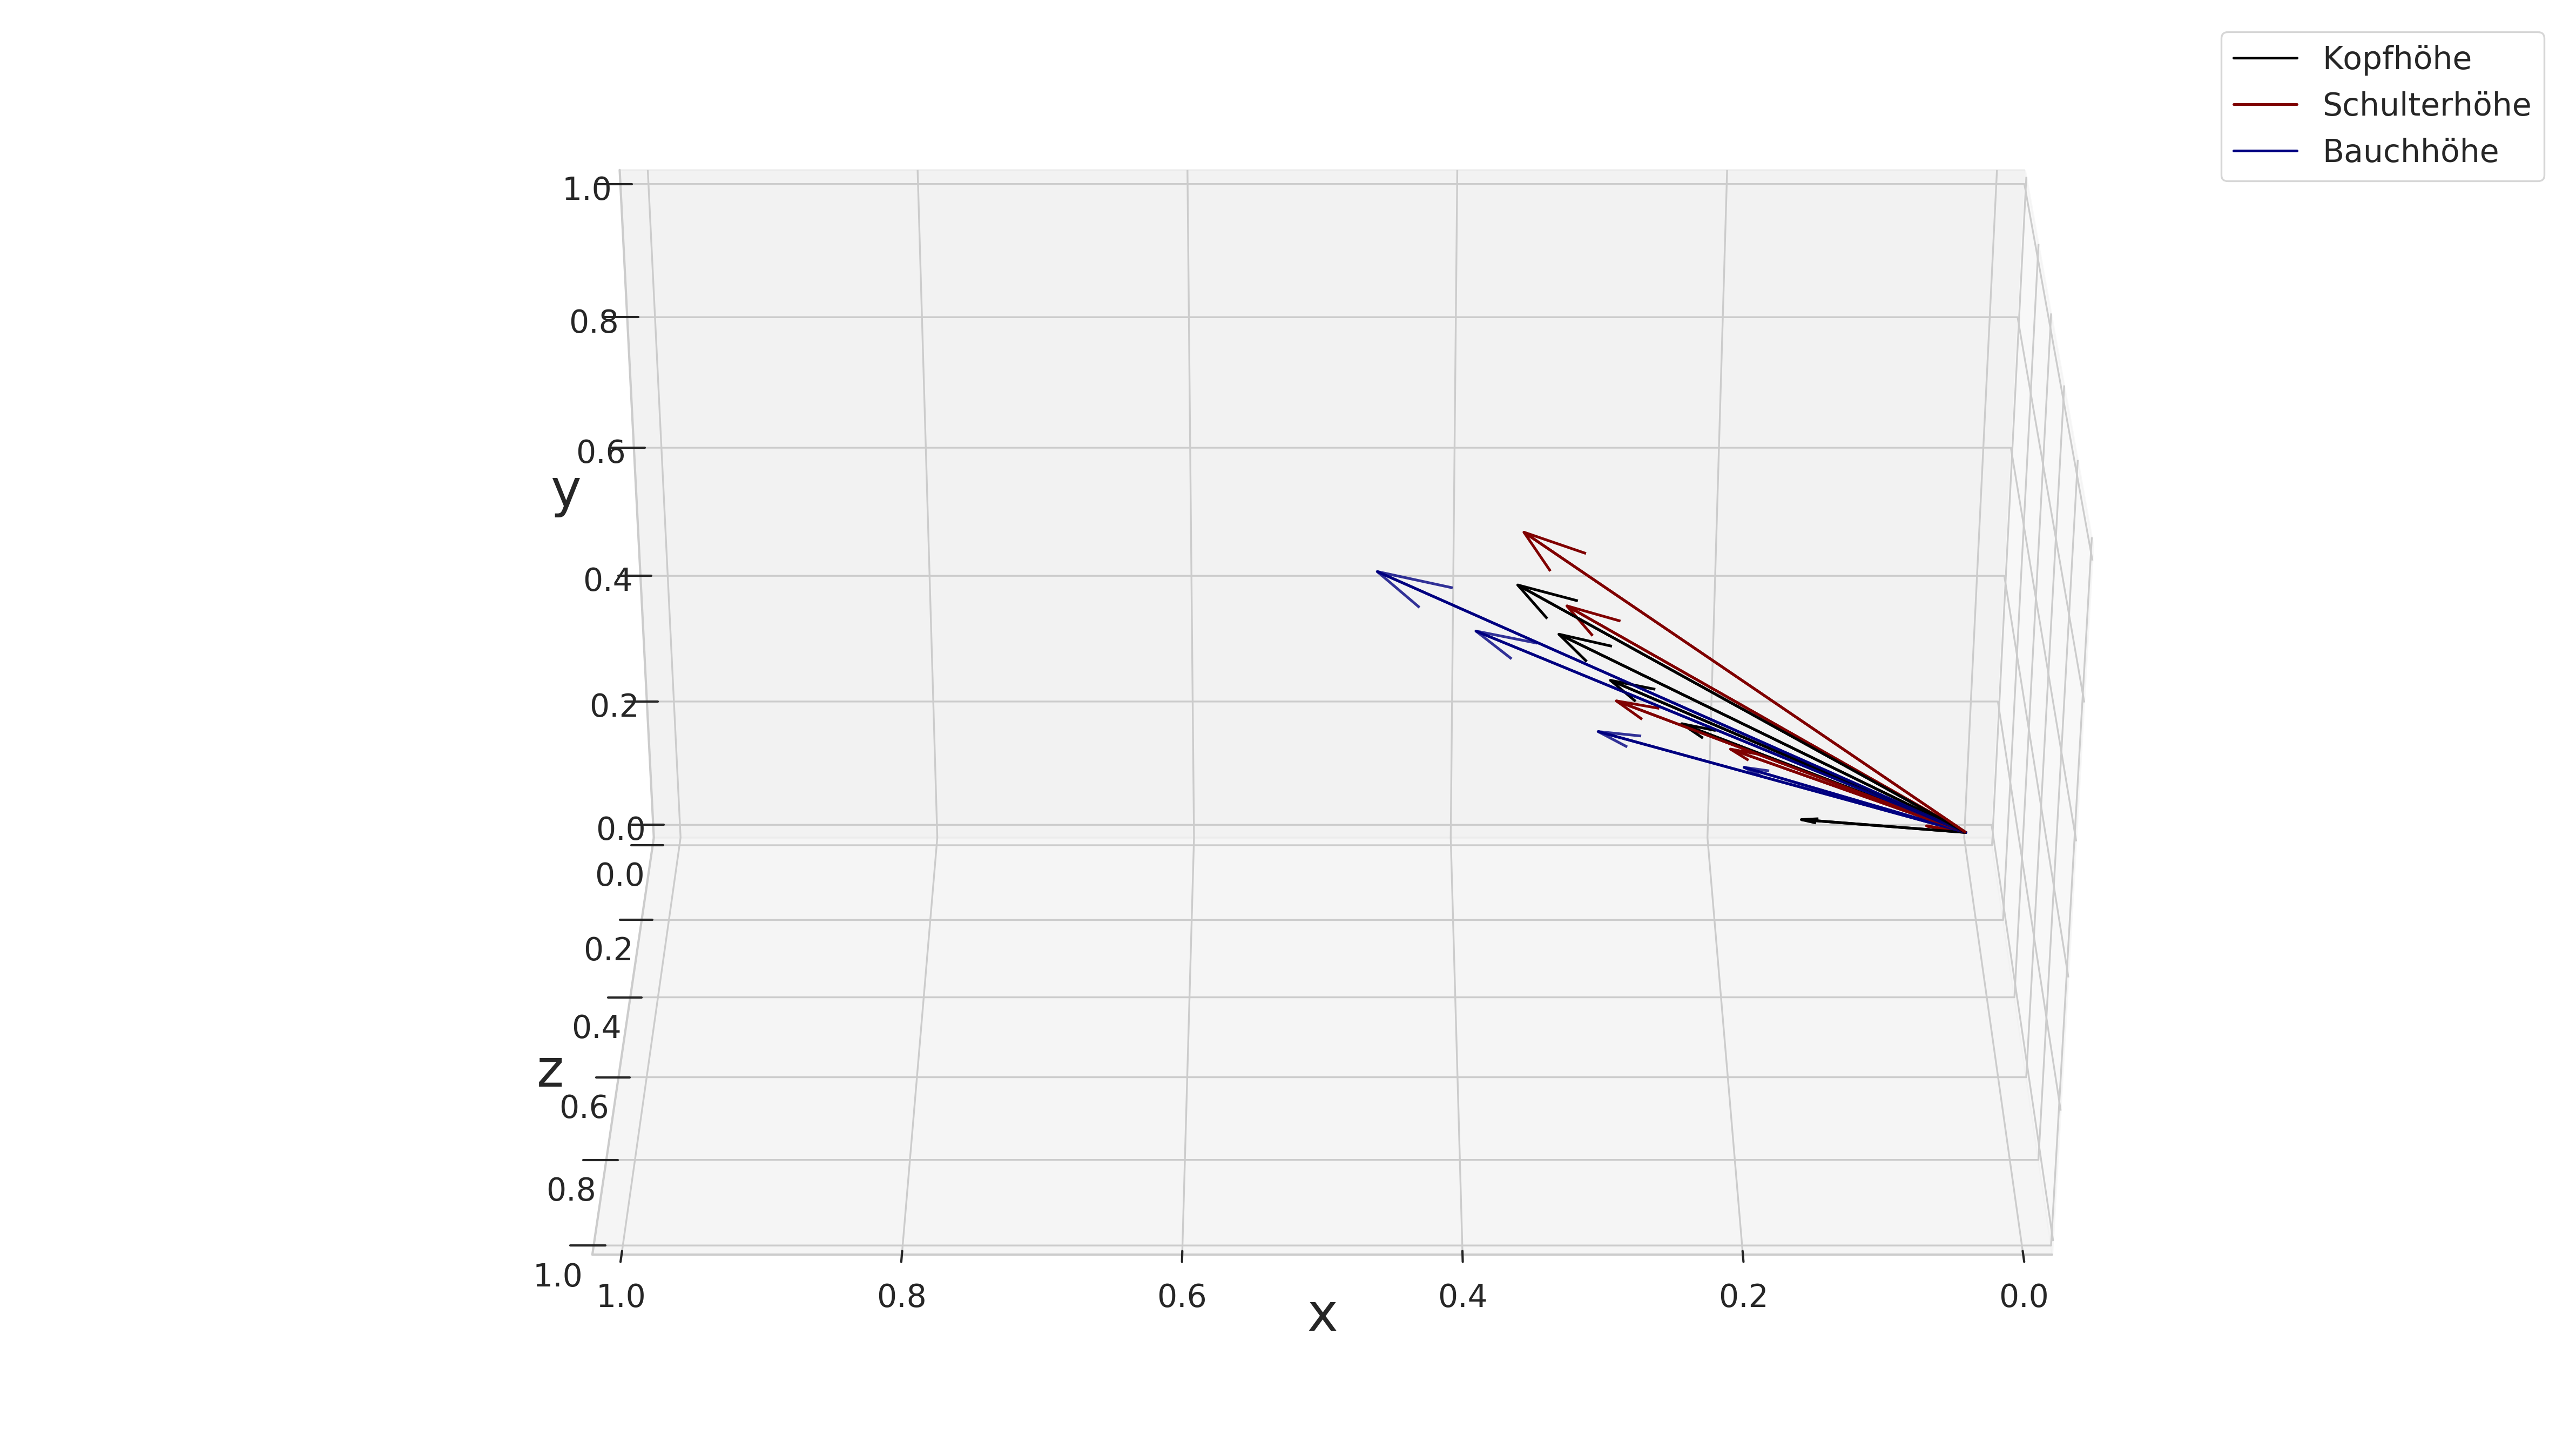

In [20]:
## PLOT FIRST SINGULAR VECTOR OF V
fig = plt.figure(figsize=(16,9))
# right hand

ax = fig.add_subplot(111, projection='3d')
counter = 0
for i in range(len(sv_r1)):
    if counter < 13:
        if counter == 0:
            c = palette1[2]
            c = 'black'
            label = 'hand; target r1'
        elif counter == 3:
            c = palette1[4]
            c = 'black'            
            label = 'wrist; target r1 '
        elif counter == 6:
            c = palette1[6]
            c = 'black'            
            label = 'lower arm; target r1'
        elif counter == 9:
            c = palette1[8]
            c = 'black'            
            label = 'upper arm; target r1'
        elif counter == 12:
            c = palette1[10]
            c = 'black'            
            label = 'shoulder; target r1'

        ax.plot(xs=(0,sv_m1[counter]), ys=(0,sv_m1[counter+2]), zs=(0,sv_m1[counter+1]), 
                color=c)
        ax.quiver(0,0, 0,sv_m1[counter],sv_m1[counter+2], sv_m1[counter+1], length = 1, arrow_length_ratio=0.1,
                  color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(sv_r)):
    if counter < 13:
        if counter == 0:
            c = palette2[2]
            c = 'maroon'            
            label = 'hand; target r2'
        elif counter == 3:
            c = palette2[4]
            c = 'maroon'
            label = 'wrist; target r2'
        elif counter == 6:
            c = palette2[6]
            c = 'maroon'
            label = 'lower arm; target r2'
        elif counter == 9:
            c = palette2[8]
            c = 'maroon'            
            label = 'upper arm; target r2'
        elif counter == 12:
            c =palette2[10]
            c = 'maroon'            
            label = 'shoulder; target r2'

        ax.plot(xs=(0,sv_m2[counter]), ys=(0,sv_m2[counter+2]), zs=(0,sv_m2[counter+1]), 
                 color=c)
        ax.quiver(0,0, 0,sv_m2[counter],sv_m2[counter+2], sv_m2[counter+1], length = 1, arrow_length_ratio=0.1,
                  label=label, color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(sv_r)):
    if counter < 13:
        if counter == 0:
            c = palette3[2]
            c = 'navy'            
            label = 'hand; taregt r3'
        elif counter == 3:
            c = palette3[4]
            c = 'navy'
            label = 'wrist; taregt r3'
        elif counter == 6:
            c = palette3[6]
            c = 'navy'
            label = 'lower arm; taregt r3'
        elif counter == 9:
            c = palette3[8]
            c = 'navy'
            label = 'upper arm; taregt r3'
        elif counter == 12:
            c = palette3[10]
            c = 'navy'
            label = 'shoulder; taregt r3'

        ax.plot(xs=(0,sv_m3[counter]), ys=(0,sv_m3[counter+2]), zs=(0,sv_m3[counter+1]), 
                color=c, linestyle='-')
        ax.quiver(0,0, 0,sv_m3[counter],sv_m3[counter+2], sv_m3[counter+1], length = 1, arrow_length_ratio=0.1,
                  color=c, alpha=0.8, linestyle='-')
        print(counter)

    counter += 3



ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)

ax.set_xlabel('x', fontsize=23)
ax.set_ylabel('z', fontsize=23)
ax.set_zlabel('y', fontsize=23)
ax.view_init(azim=90)
r1_line = mlines.Line2D([], [], color='Black', label='Kopfhöhe')
r2_line = mlines.Line2D([], [], color='maroon', label='Schulterhöhe')
r3_line = mlines.Line2D([], [], color='navy', label='Bauchhöhe')
plt.legend(handles=[r1_line, r2_line, r3_line])
plt.show()

0
3
6
9
12
0
3
6
9
12
0
3
6
9
12


/home/michael/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


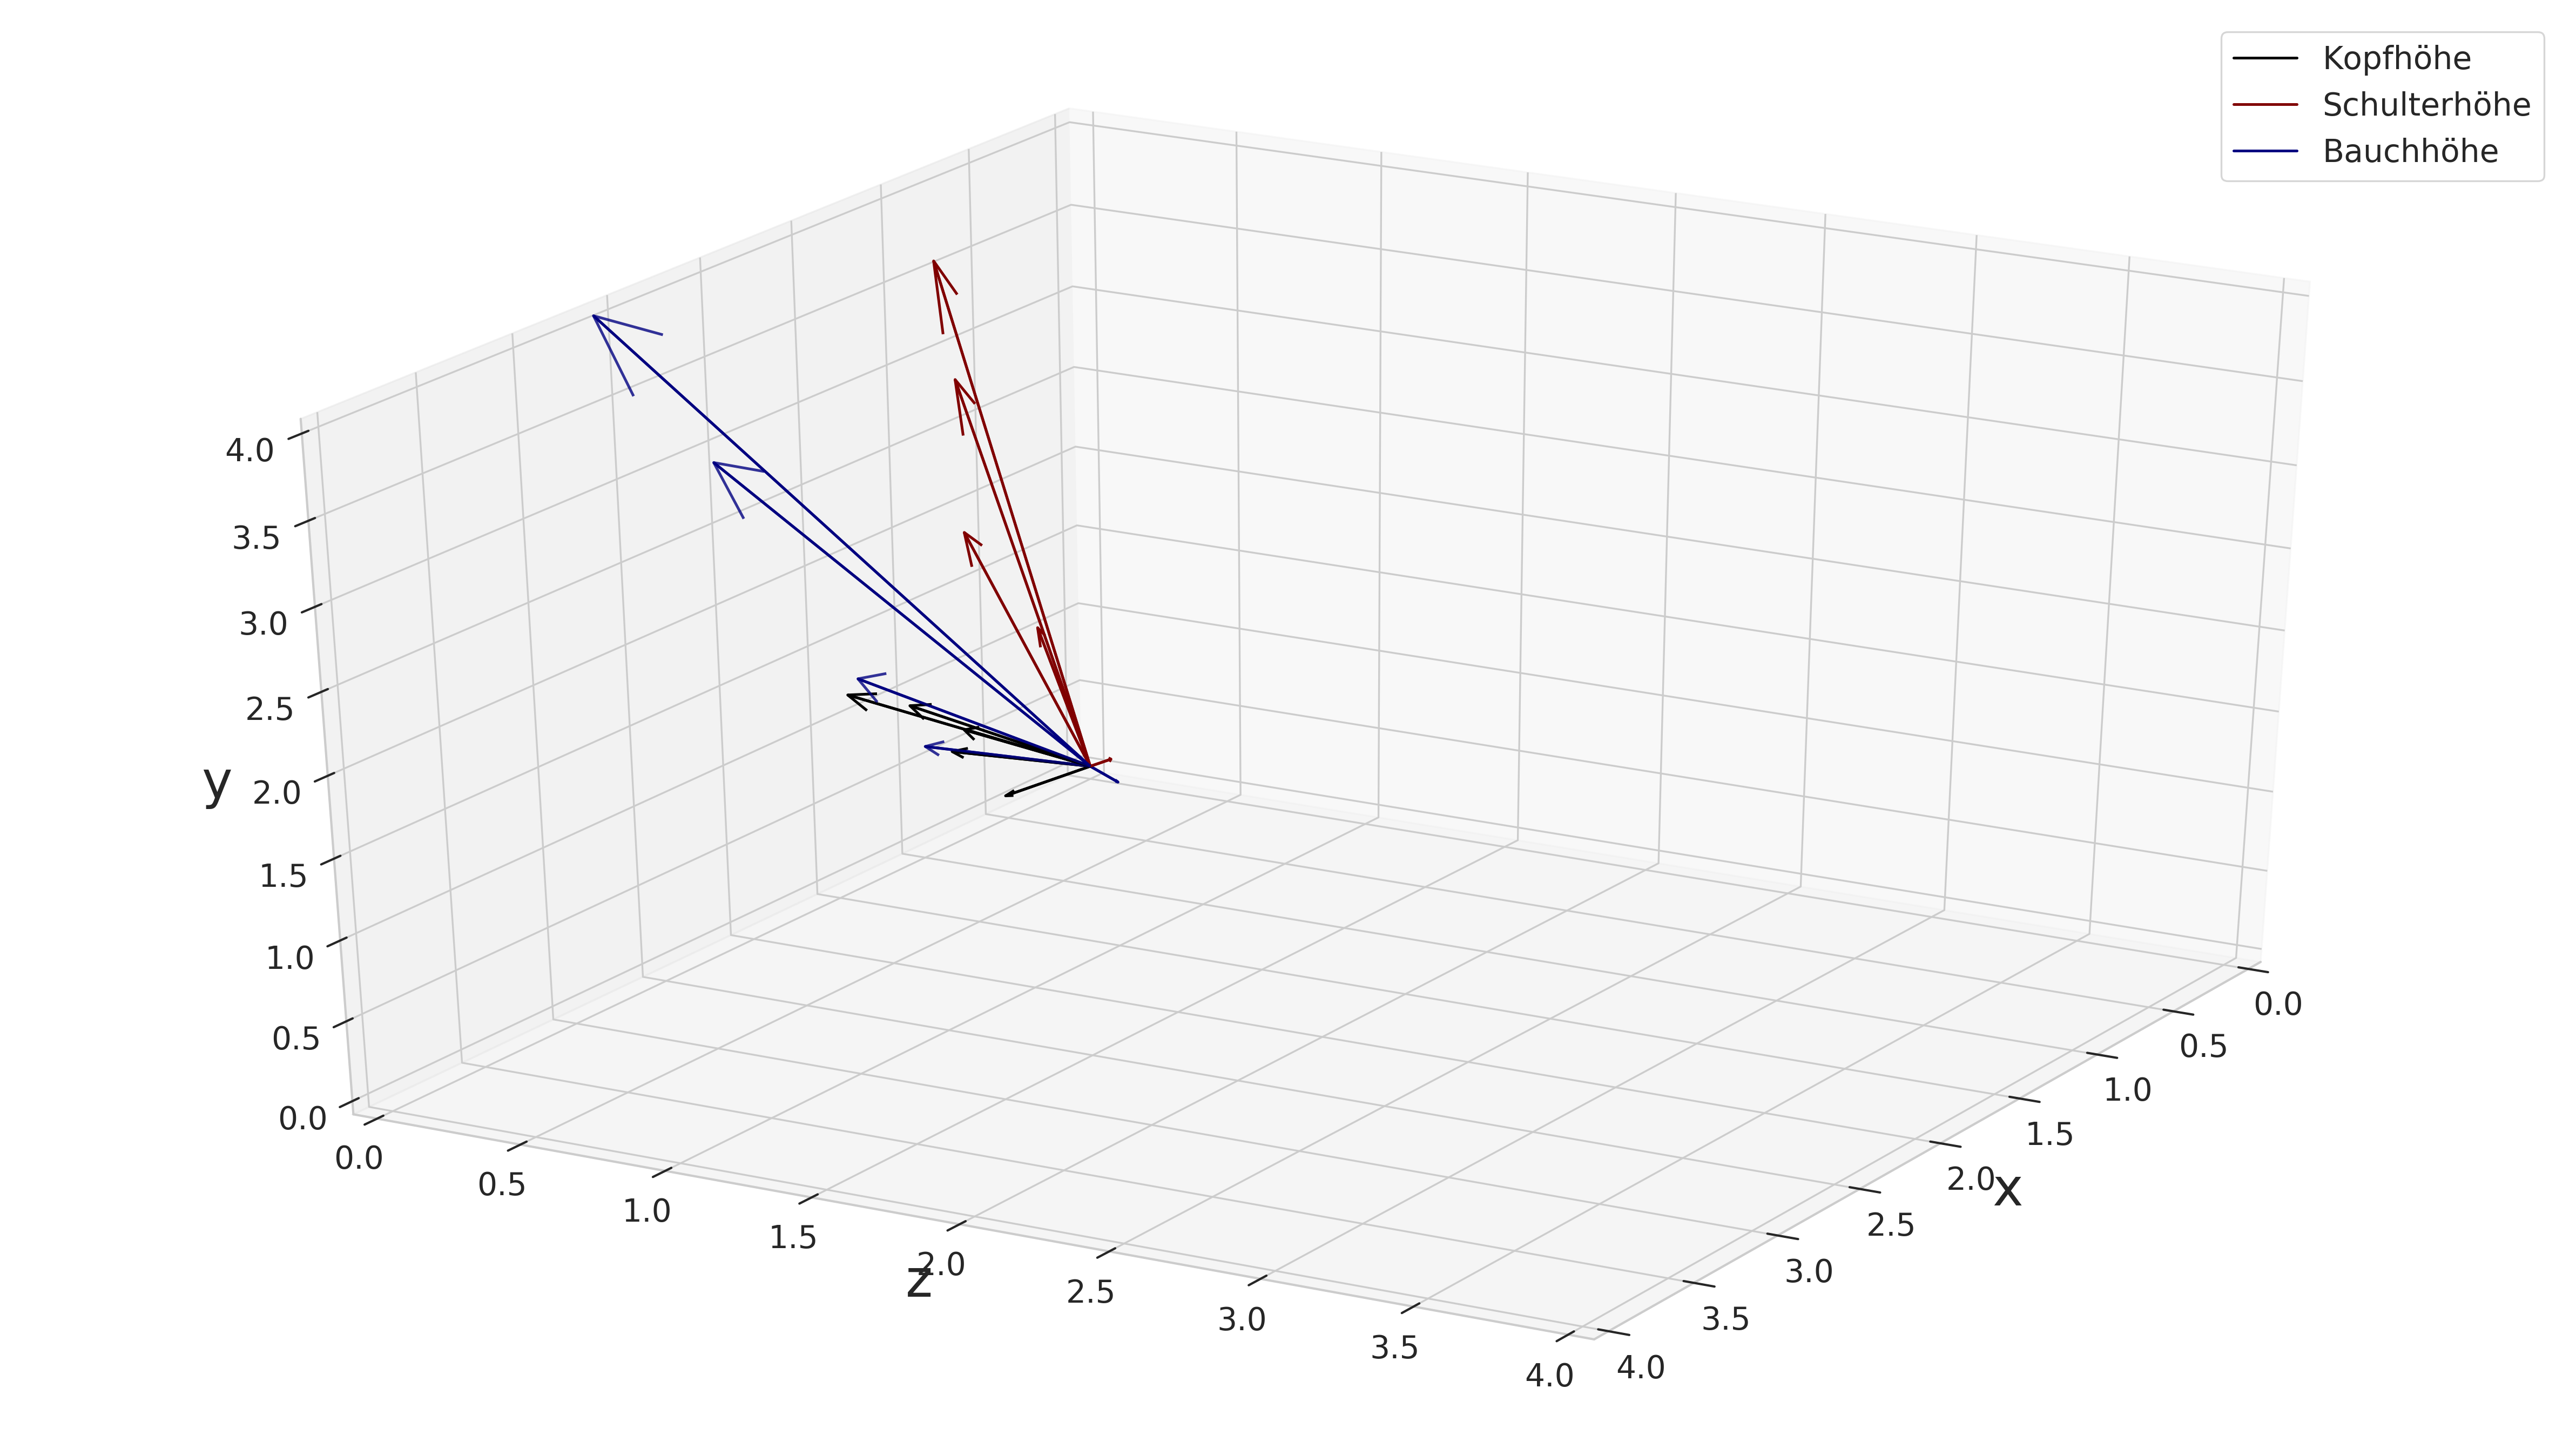

In [21]:
## PLOT FIRST SINGULAR VECTOR OF V
fig = plt.figure(figsize=(16,9))
# right hand

ax = fig.add_subplot(111, projection='3d')
counter = 0
for i in range(len(svt_r1)):
    if counter < 13:
        if counter == 0:
            c = palette1[2]
            c = 'black'
            label = 'hand; target r1'
        elif counter == 3:
            c = palette1[4]
            c = 'black'            
            label = 'wrist; target r1 '
        elif counter == 6:
            c = palette1[6]
            c = 'black'            
            label = 'lower arm; target r1'
        elif counter == 9:
            c = palette1[8]
            c = 'black'            
            label = 'upper arm; target r1'
        elif counter == 12:
            c = palette1[10]
            c = 'black'            
            label = 'shoulder; target r1'

        ax.plot(xs=(0,svt_r1[counter]), ys=(0,svt_r1[counter+2]), zs=(0,svt_r1[counter+1]), 
                color=c)
        ax.quiver(0,0, 0,svt_r1[counter],svt_r1[counter+2], svt_r1[counter+1], length = 1, arrow_length_ratio=0.1,
                  color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(svt_r)):
    if counter < 13:
        if counter == 0:
            c = palette2[2]
            c = 'maroon'            
            label = 'hand; target r2'
        elif counter == 3:
            c = palette2[4]
            c = 'maroon'
            label = 'wrist; target r2'
        elif counter == 6:
            c = palette2[6]
            c = 'maroon'
            label = 'lower arm; target r2'
        elif counter == 9:
            c = palette2[8]
            c = 'maroon'            
            label = 'upper arm; target r2'
        elif counter == 12:
            c =palette2[10]
            c = 'maroon'            
            label = 'shoulder; target r2'

        ax.plot(xs=(0,svt_r2[counter]), ys=(0,svt_r2[counter+2]), zs=(0,svt_r2[counter+1]), 
                 color=c)
        ax.quiver(0,0, 0,svt_r2[counter],svt_r2[counter+2], svt_r2[counter+1], length = 1, arrow_length_ratio=0.1,
                  color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(svt_r)):
    if counter < 13:
        if counter == 0:
            c = palette3[2]
            c = 'navy'            
            label = 'hand; taregt r3'
        elif counter == 3:
            c = palette3[4]
            c = 'navy'
            label = 'wrist; taregt r3'
        elif counter == 6:
            c = palette3[6]
            c = 'navy'
            label = 'lower arm; taregt r3'
        elif counter == 9:
            c = palette3[8]
            c = 'navy'
            label = 'upper arm; taregt r3'
        elif counter == 12:
            c = palette3[10]
            c = 'navy'
            label = 'shoulder; taregt r3'

        ax.plot(xs=(0,svt_r3[counter]), ys=(0,svt_r3[counter+2]), zs=(0,svt_r3[counter+1]), 
                color=c, linestyle='-')
        ax.quiver(0,0, 0,svt_r3[counter],svt_r3[counter+2], svt_r3[counter+1], length = 1, arrow_length_ratio=0.1,
                  color=c, alpha=0.8, linestyle='-')
        print(counter)

    counter += 3


ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_zlim(0,4)


ax.set_xlabel('x', fontsize=23)
ax.set_ylabel('z', fontsize=23)
ax.set_zlabel('y', fontsize=23)
ax.view_init(azim=30)
r1_line = mlines.Line2D([], [], color='Black', label='Kopfhöhe')
r2_line = mlines.Line2D([], [], color='maroon', label='Schulterhöhe')
r3_line = mlines.Line2D([], [], color='navy', label='Bauchhöhe')
plt.legend(handles=[r1_line, r2_line, r3_line])
plt.show()

0
3
6
9
12
0
3
6
9
12
0
3
6
9
12


/home/michael/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


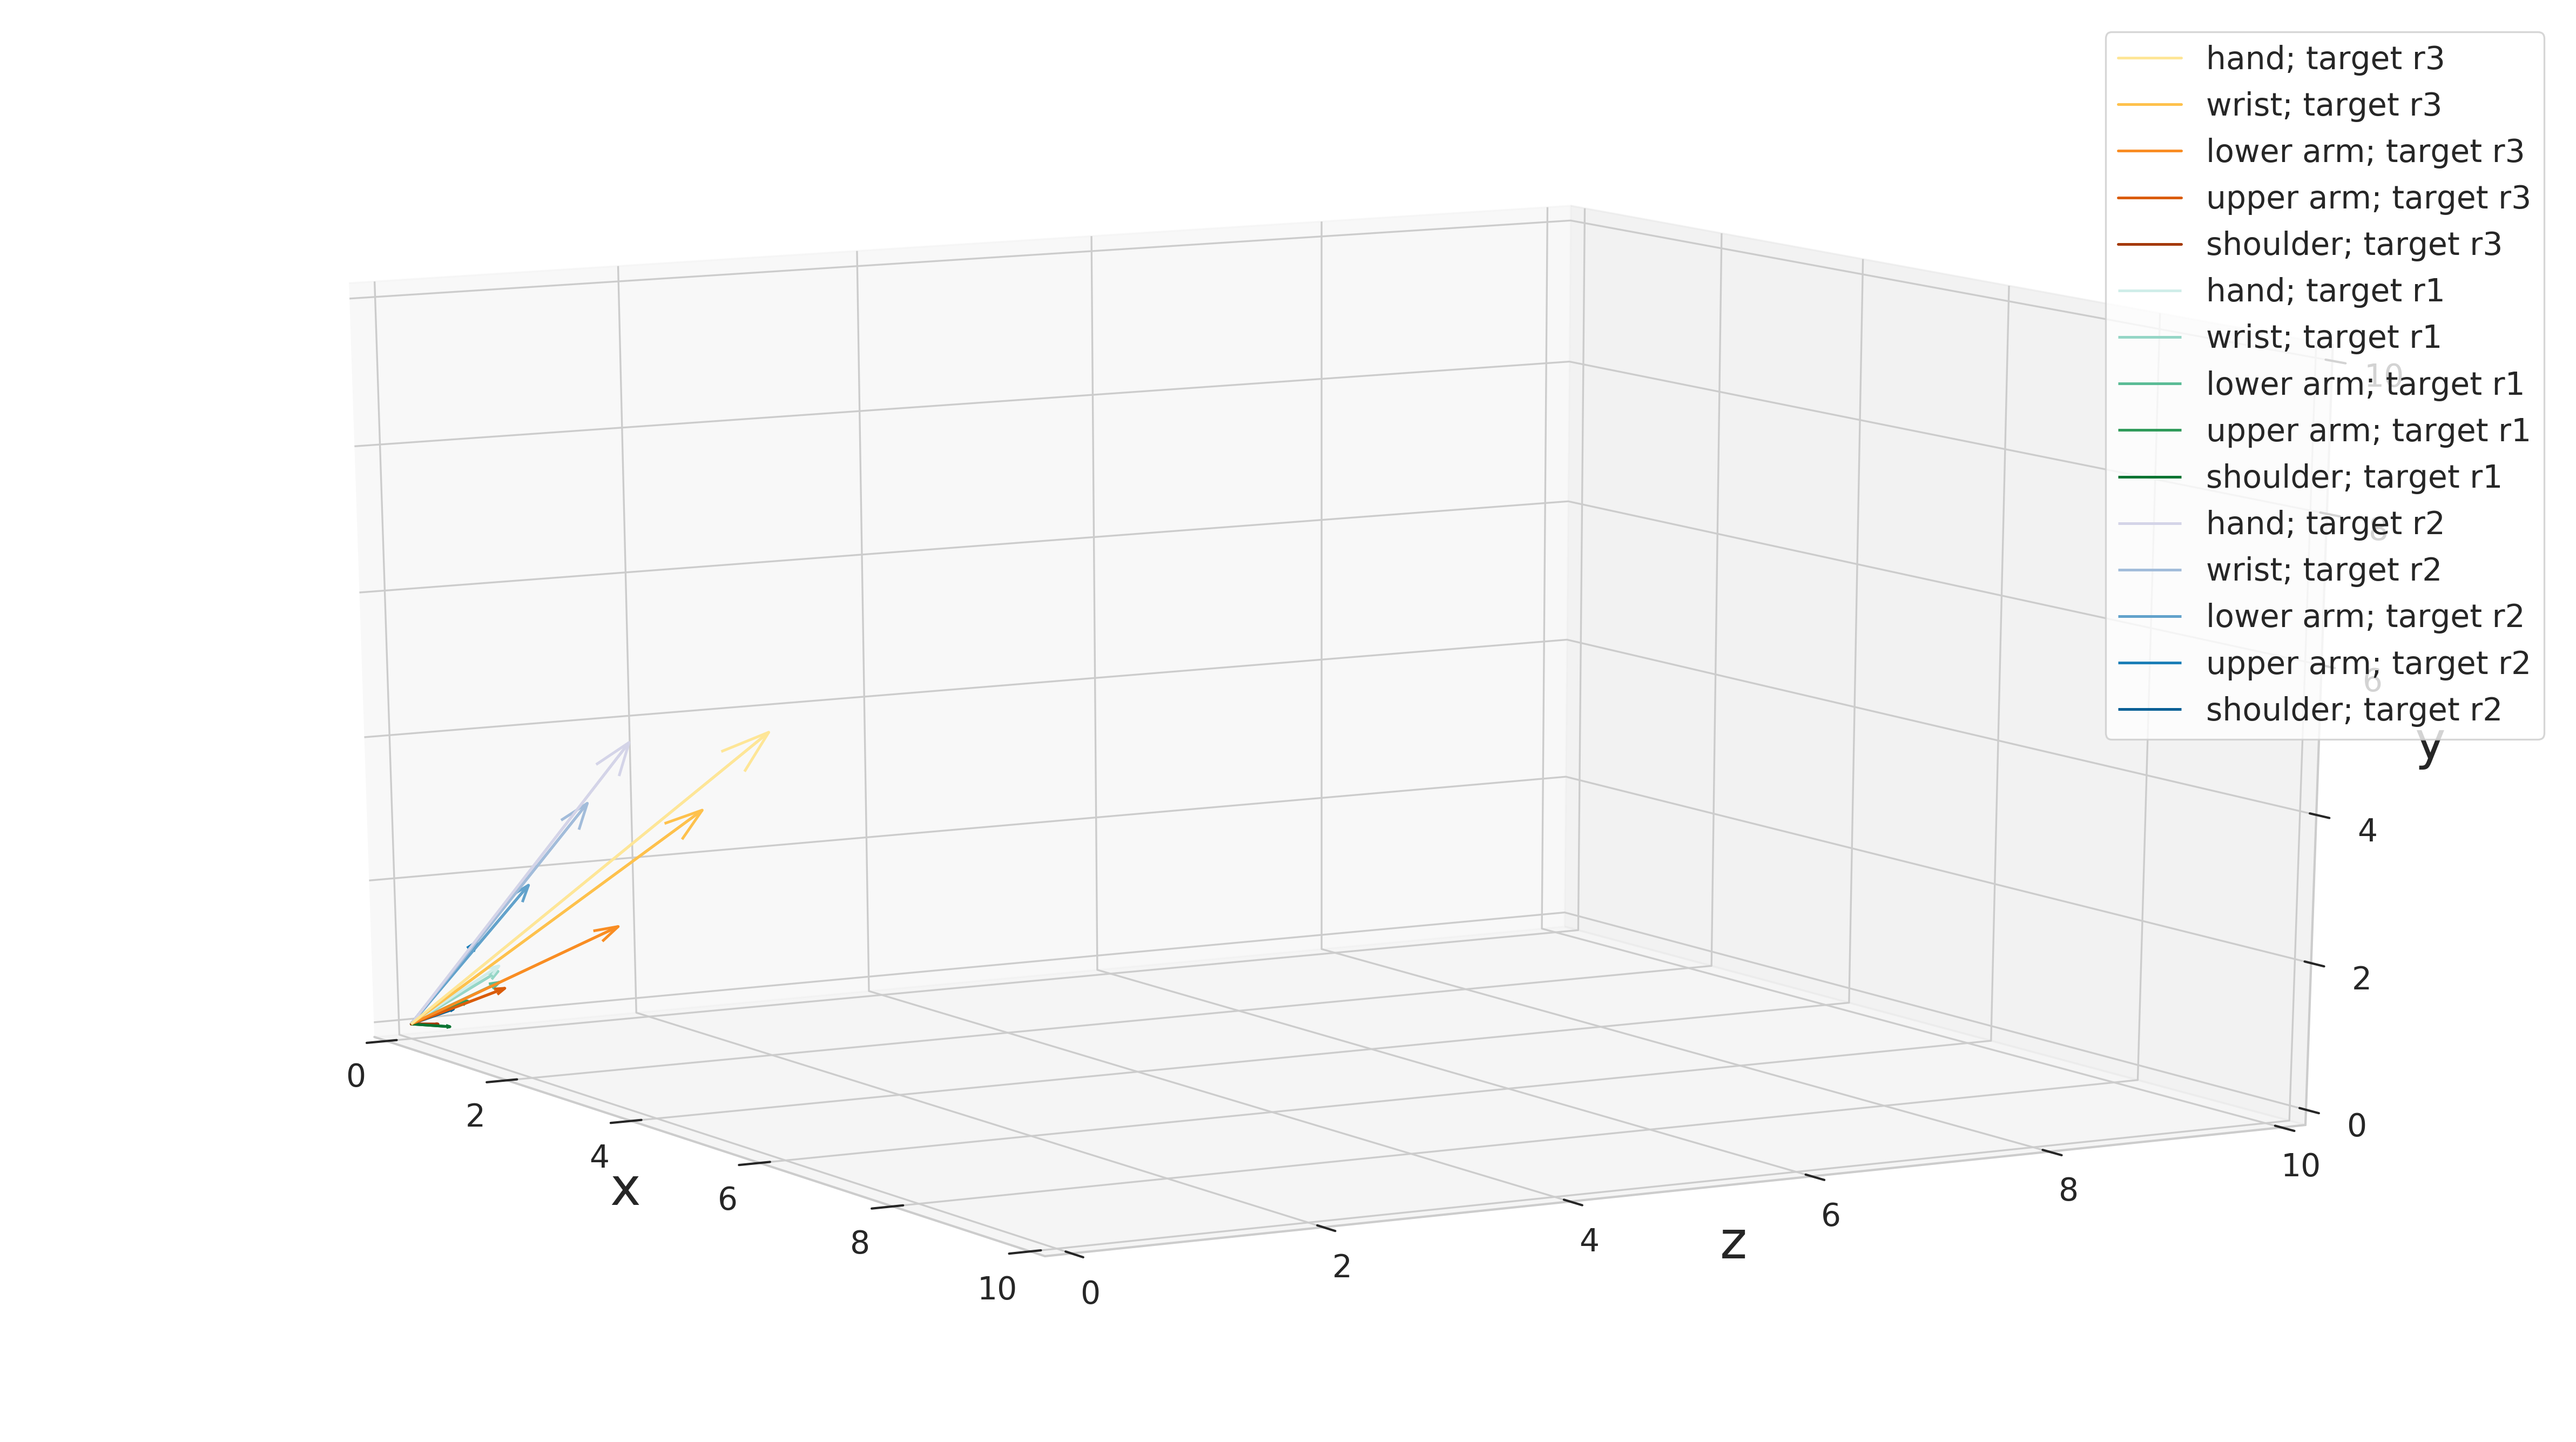

In [22]:
## PLOT FIRST SINGULAR VECTOR OF V
fig = plt.figure(figsize=(16,9))
# right hand

ax = fig.add_subplot(111, projection='3d')
counter = 0
for i in range(len(svt_r1)):
    if counter < 13:
        if counter == 0:
            c = palette1[2]
#             c = 'black'
            label = 'hand; target r1'
        elif counter == 3:
            c = palette1[4]
#             c = 'black'            
            label = 'wrist; target r1 '
        elif counter == 6:
            c = palette1[6]
#             c = 'black'            
            label = 'lower arm; target r1'
        elif counter == 9:
            c = palette1[8]
#             c = 'black'            
            label = 'upper arm; target r1'
        elif counter == 12:
            c = palette1[10]
#             c = 'black'            
            label = 'shoulder; target r1'

        ax.plot(xs=(0,svt_r1[counter]), ys=(0,svt_r1[counter+2]), zs=(0,svt_r1[counter+1]), 
                color=c)
        ax.quiver(0,0, 0,svt_r1[counter],svt_r1[counter+2], svt_r1[counter+1], length = 1, arrow_length_ratio=0.1,
                  label=label, color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(svt_r)):
    if counter < 13:
        if counter == 0:
            c = palette2[2]
#             c = 'maroon'            
            label = 'hand; target r2'
        elif counter == 3:
            c = palette2[4]
#             c = 'maroon'
            label = 'wrist; target r2'
        elif counter == 6:
            c = palette2[6]
#             c = 'maroon'
            label = 'lower arm; target r2'
        elif counter == 9:
            c = palette2[8]
#             c = 'maroon'            
            label = 'upper arm; target r2'
        elif counter == 12:
            c =palette2[10]
#             c = 'maroon'            
            label = 'shoulder; target r2'

        ax.plot(xs=(0,svt_r2[counter]), ys=(0,svt_r2[counter+2]), zs=(0,svt_r2[counter+1]), 
                 color=c)
        ax.quiver(0,0, 0,svt_r2[counter],svt_r2[counter+2], svt_r2[counter+1], length = 1, arrow_length_ratio=0.1,
                  label=label, color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(svt_r)):
    if counter < 13:
        if counter == 0:
            c = palette3[2]
#             c = 'navy'            
            label = 'hand; target r3'
        elif counter == 3:
            c = palette3[4]
#             c = 'navy'
            label = 'wrist; target r3'
        elif counter == 6:
            c = palette3[6]
#             c = 'navy'
            label = 'lower arm; target r3'
        elif counter == 9:
            c = palette3[8]
#             c = 'navy'
            label = 'upper arm; target r3'
        elif counter == 12:
            c = palette3[10]
#             c = 'navy'
            label = 'shoulder; target r3'

        ax.plot(xs=(0,svt_r3[counter]), ys=(0,svt_r3[counter+2]), zs=(0,svt_r3[counter+1]), 
                color=c, label=label, linestyle='-')
        ax.quiver(0,0, 0,svt_r3[counter],svt_r3[counter+2], svt_r3[counter+1], length = 1, arrow_length_ratio=0.1,
                color=c)
        print(counter)

    counter += 3



ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_zlim(0,10)



ax.set_xlabel('x', fontsize=23)
ax.set_ylabel('z', fontsize=23)
ax.set_zlabel('y', fontsize=23)
ax.view_init(azim=310)
plt.legend()
# r1_line = mlines.Line2D([], [], color='Black', label='Kopfhöhe')
# r2_line = mlines.Line2D([], [], color='maroon', label='Schulterhöhe')
# r3_line = mlines.Line2D([], [], color='navy', label='Bauchhöhe')
# plt.legend(handles=[r1_line, r2_line, r3_line])
try:
    os.makedirs('/home/michael/view_svt/r/'+subj+'/')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
    # get DATA

for deg in range(0,360,30):
    ax.view_init(elev=15., azim=deg)
    plt.savefig('/home/michael/view_svt/r/{a}/{a}_r_{b}d_svt.png'.format(a=subj, b=deg))

0
3
6
9
12
0
3
6
9
12
0
3
6
9
12


/home/michael/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


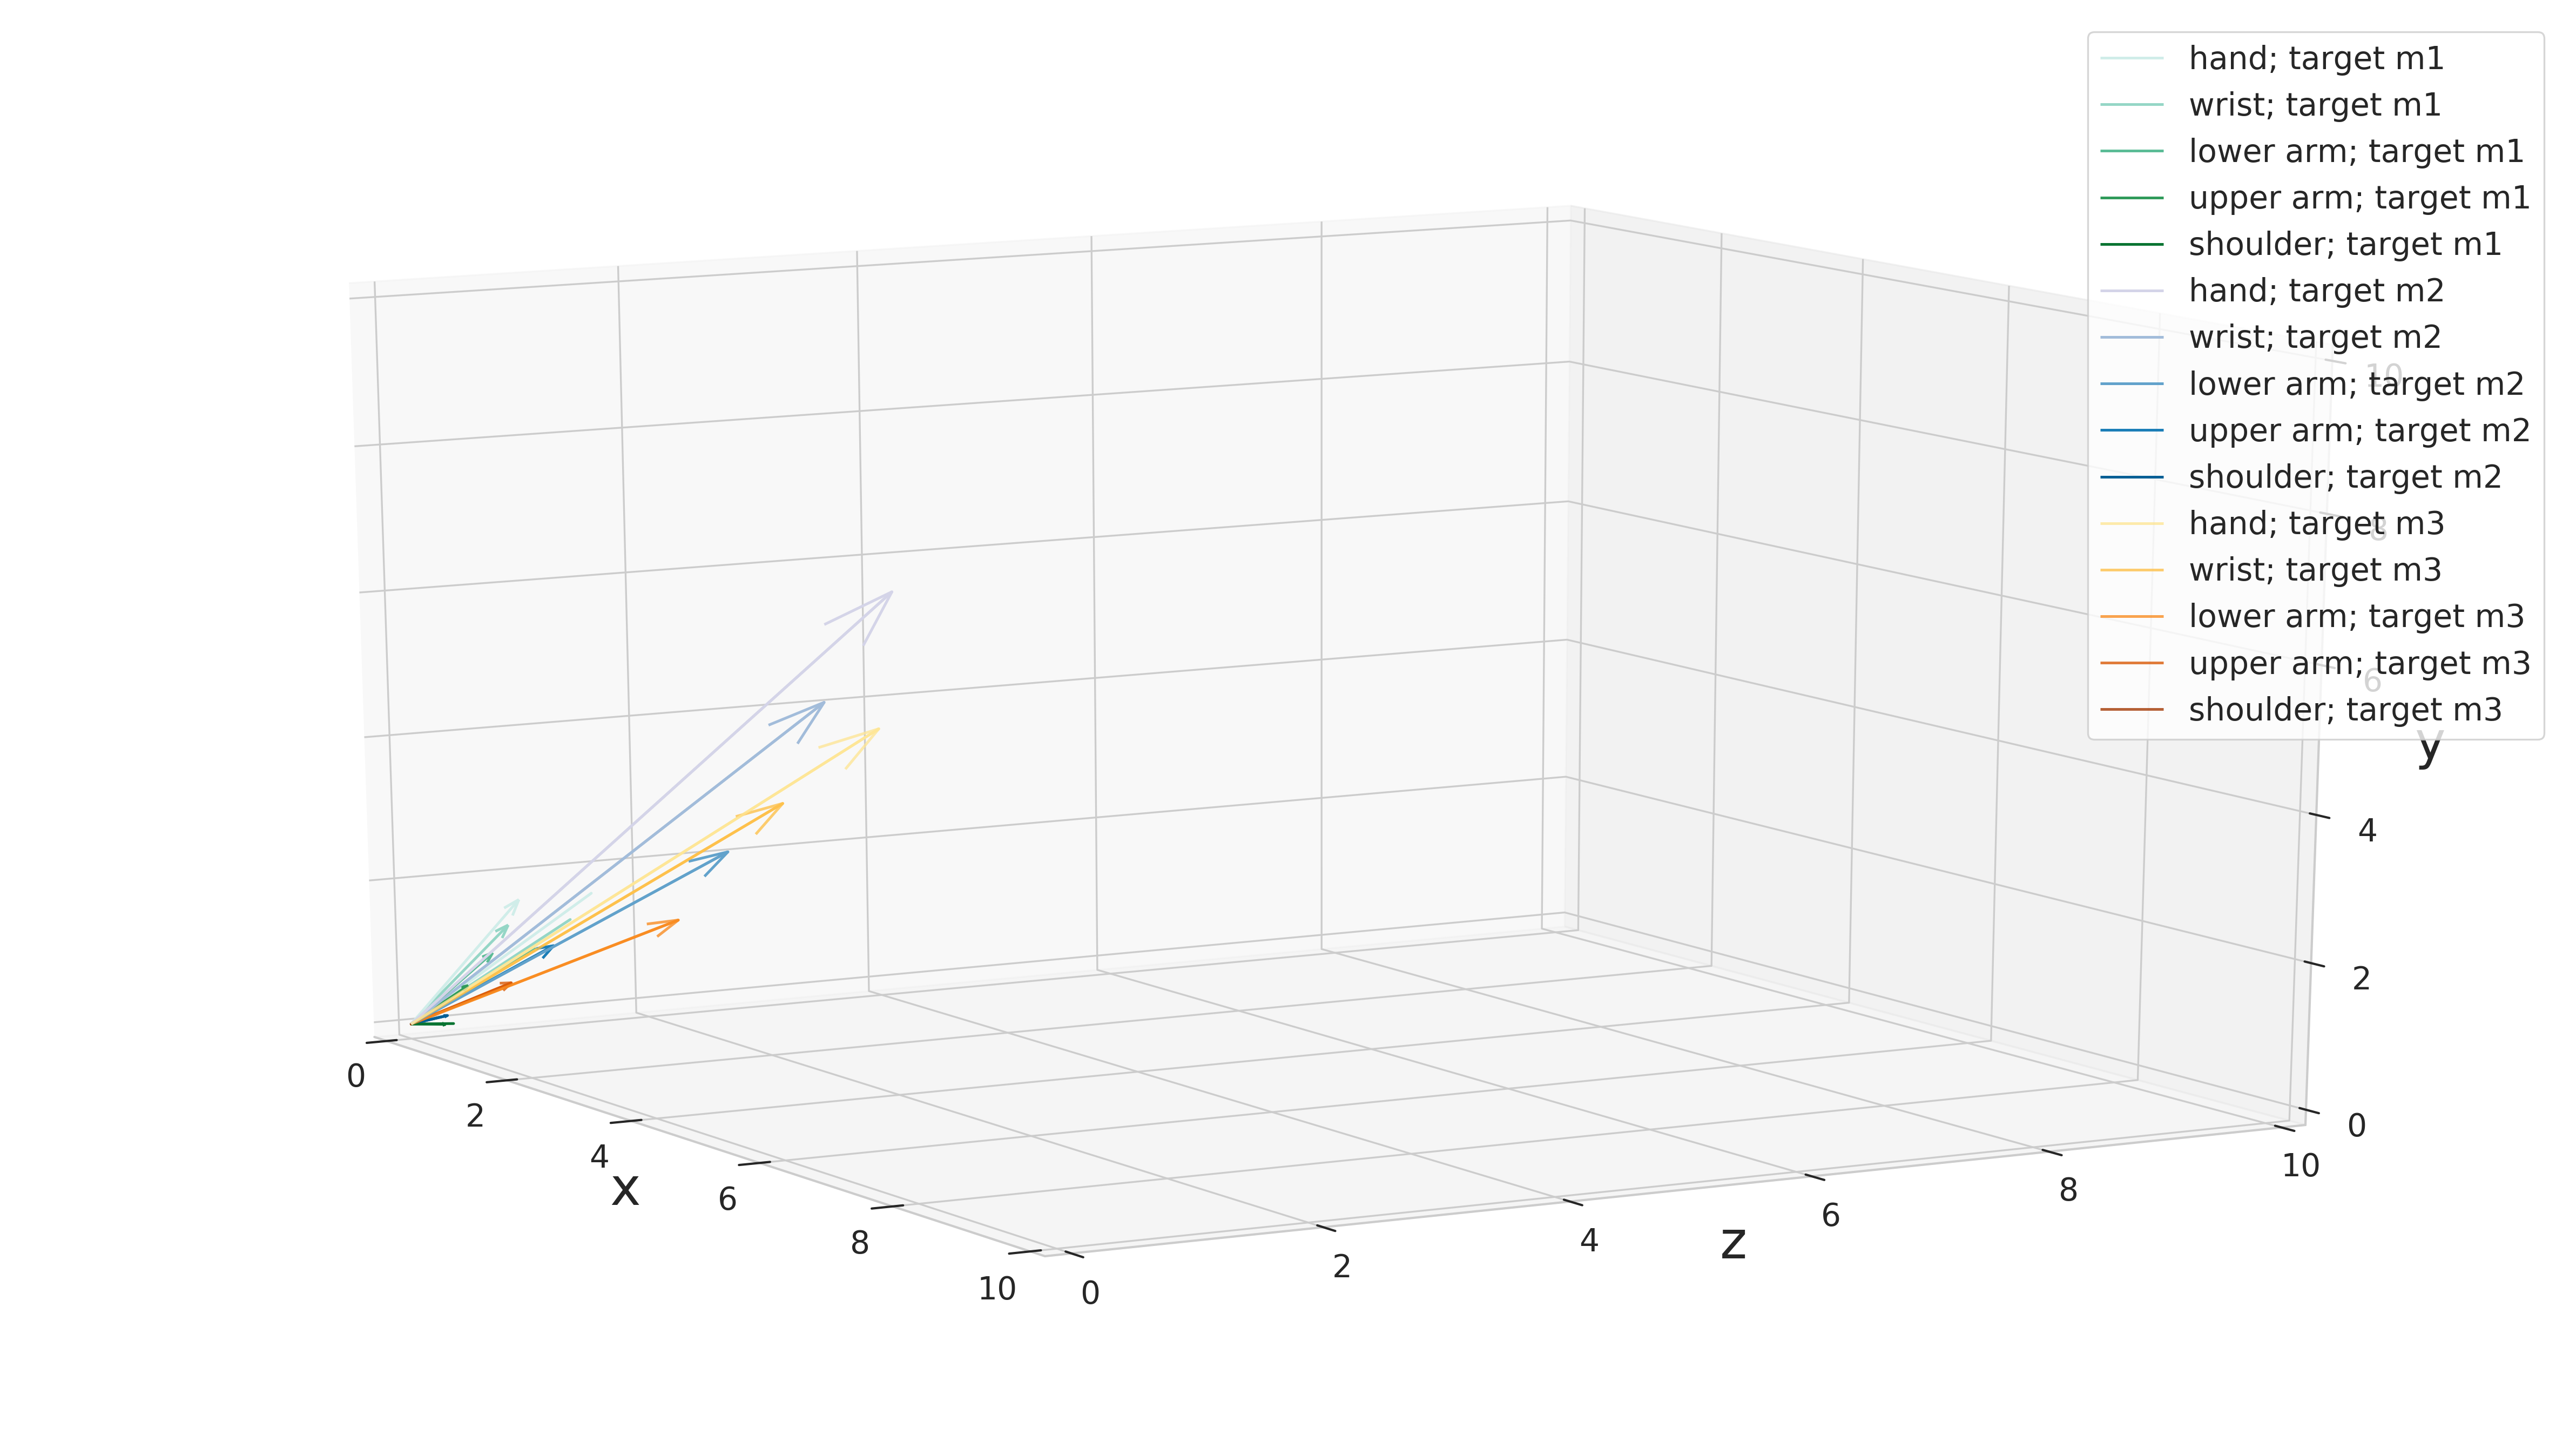

In [23]:
## PLOT FIRST SINGULAR VECTOR OF V
fig = plt.figure(figsize=(16,9))
# right hand

ax = fig.add_subplot(111, projection='3d')
counter = 0
for i in range(len(svt_r1)):
    if counter < 13:
        if counter == 0:
            c = palette1[2]
#             c = 'black'
            label = 'hand; target m1'
        elif counter == 3:
            c = palette1[4]
#             c = 'black'            
            label = 'wrist; target m1'
        elif counter == 6:
            c = palette1[6]
#             c = 'black'            
            label = 'lower arm; target m1'
        elif counter == 9:
            c = palette1[8]
#             c = 'black'            
            label = 'upper arm; target m1'
        elif counter == 12:
            c = palette1[10]
#             c = 'black'            
            label = 'shoulder; target m1'

        ax.plot(xs=(0,svt_m1[counter]), ys=(0,svt_m1[counter+2]), zs=(0,svt_m1[counter+1]), 
                color=c)
        ax.quiver(0,0, 0,svt_m1[counter],sv_m1[counter+2], svt_m1[counter+1], length = 1, arrow_length_ratio=0.1,
                  label=label, color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(svt_r)):
    if counter < 13:
        if counter == 0:
            c = palette2[2]
#             c = 'maroon'            
            label = 'hand; target m2'
        elif counter == 3:
            c = palette2[4]
#             c = 'maroon'
            label = 'wrist; target m2'
        elif counter == 6:
            c = palette2[6]
#             c = 'maroon'
            label = 'lower arm; target m2'
        elif counter == 9:
            c = palette2[8]
#             c = 'maroon'            
            label = 'upper arm; target m2'
        elif counter == 12:
            c =palette2[10]
#             c = 'maroon'            
            label = 'shoulder; target m2'

        ax.plot(xs=(0,svt_m2[counter]), ys=(0,svt_m2[counter+2]), zs=(0,svt_m2[counter+1]), 
                 color=c)
        ax.quiver(0,0, 0,svt_m2[counter],svt_m2[counter+2], svt_m2[counter+1], length = 1, arrow_length_ratio=0.1,
                  label=label, color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(sv_r)):
    if counter < 13:
        if counter == 0:
            c = palette3[2]
#             c = 'navy'            
            label = 'hand; target m3'
        elif counter == 3:
            c = palette3[4]
#             c = 'navy'
            label = 'wrist; target m3'
        elif counter == 6:
            c = palette3[6]
#             c = 'navy'
            label = 'lower arm; target m3'
        elif counter == 9:
            c = palette3[8]
#             c = 'navy'
            label = 'upper arm; target m3'
        elif counter == 12:
            c = palette3[10]
#             c = 'navy'
            label = 'shoulder; target m3'

        ax.plot(xs=(0,svt_m3[counter]), ys=(0,svt_m3[counter+2]), zs=(0,svt_m3[counter+1]), 
                color=c, linestyle='-')
        ax.quiver(0,0, 0,svt_m3[counter],svt_m3[counter+2], svt_m3[counter+1], length = 1, arrow_length_ratio=0.1,
                  label=label, color=c, alpha=0.8, linestyle='-')
        print(counter)

    counter += 3



ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_zlim(0,10)


ax.set_xlabel('x', fontsize=23)
ax.set_ylabel('z', fontsize=23)
ax.set_zlabel('y', fontsize=23)
ax.view_init(azim=0)
# r1_line = mlines.Line2D([], [], color='Black', label='Kopfhöhe')
# r2_line = mlines.Line2D([], [], color='maroon', label='Schulterhöhe')
# r3_line = mlines.Line2D([], [], color='navy', label='Bauchhöhe')
# plt.legend(handles=[r1_line, r2_line, r3_line])
plt.legend()

try:
    os.makedirs('/home/michael/view_svt/m/'+subj+'/')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
    # get DATA

for deg in range(0,360,30):
    ax.view_init(elev=15., azim=deg)
    plt.savefig('/home/michael/view_svt/m/{a}/{a}_m_{b}d_svt.png'.format(a=subj, b=deg))
    
plt.show()

0
3
6
9
12
0
3
6
9
12
0
3
6
9
12


/home/michael/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


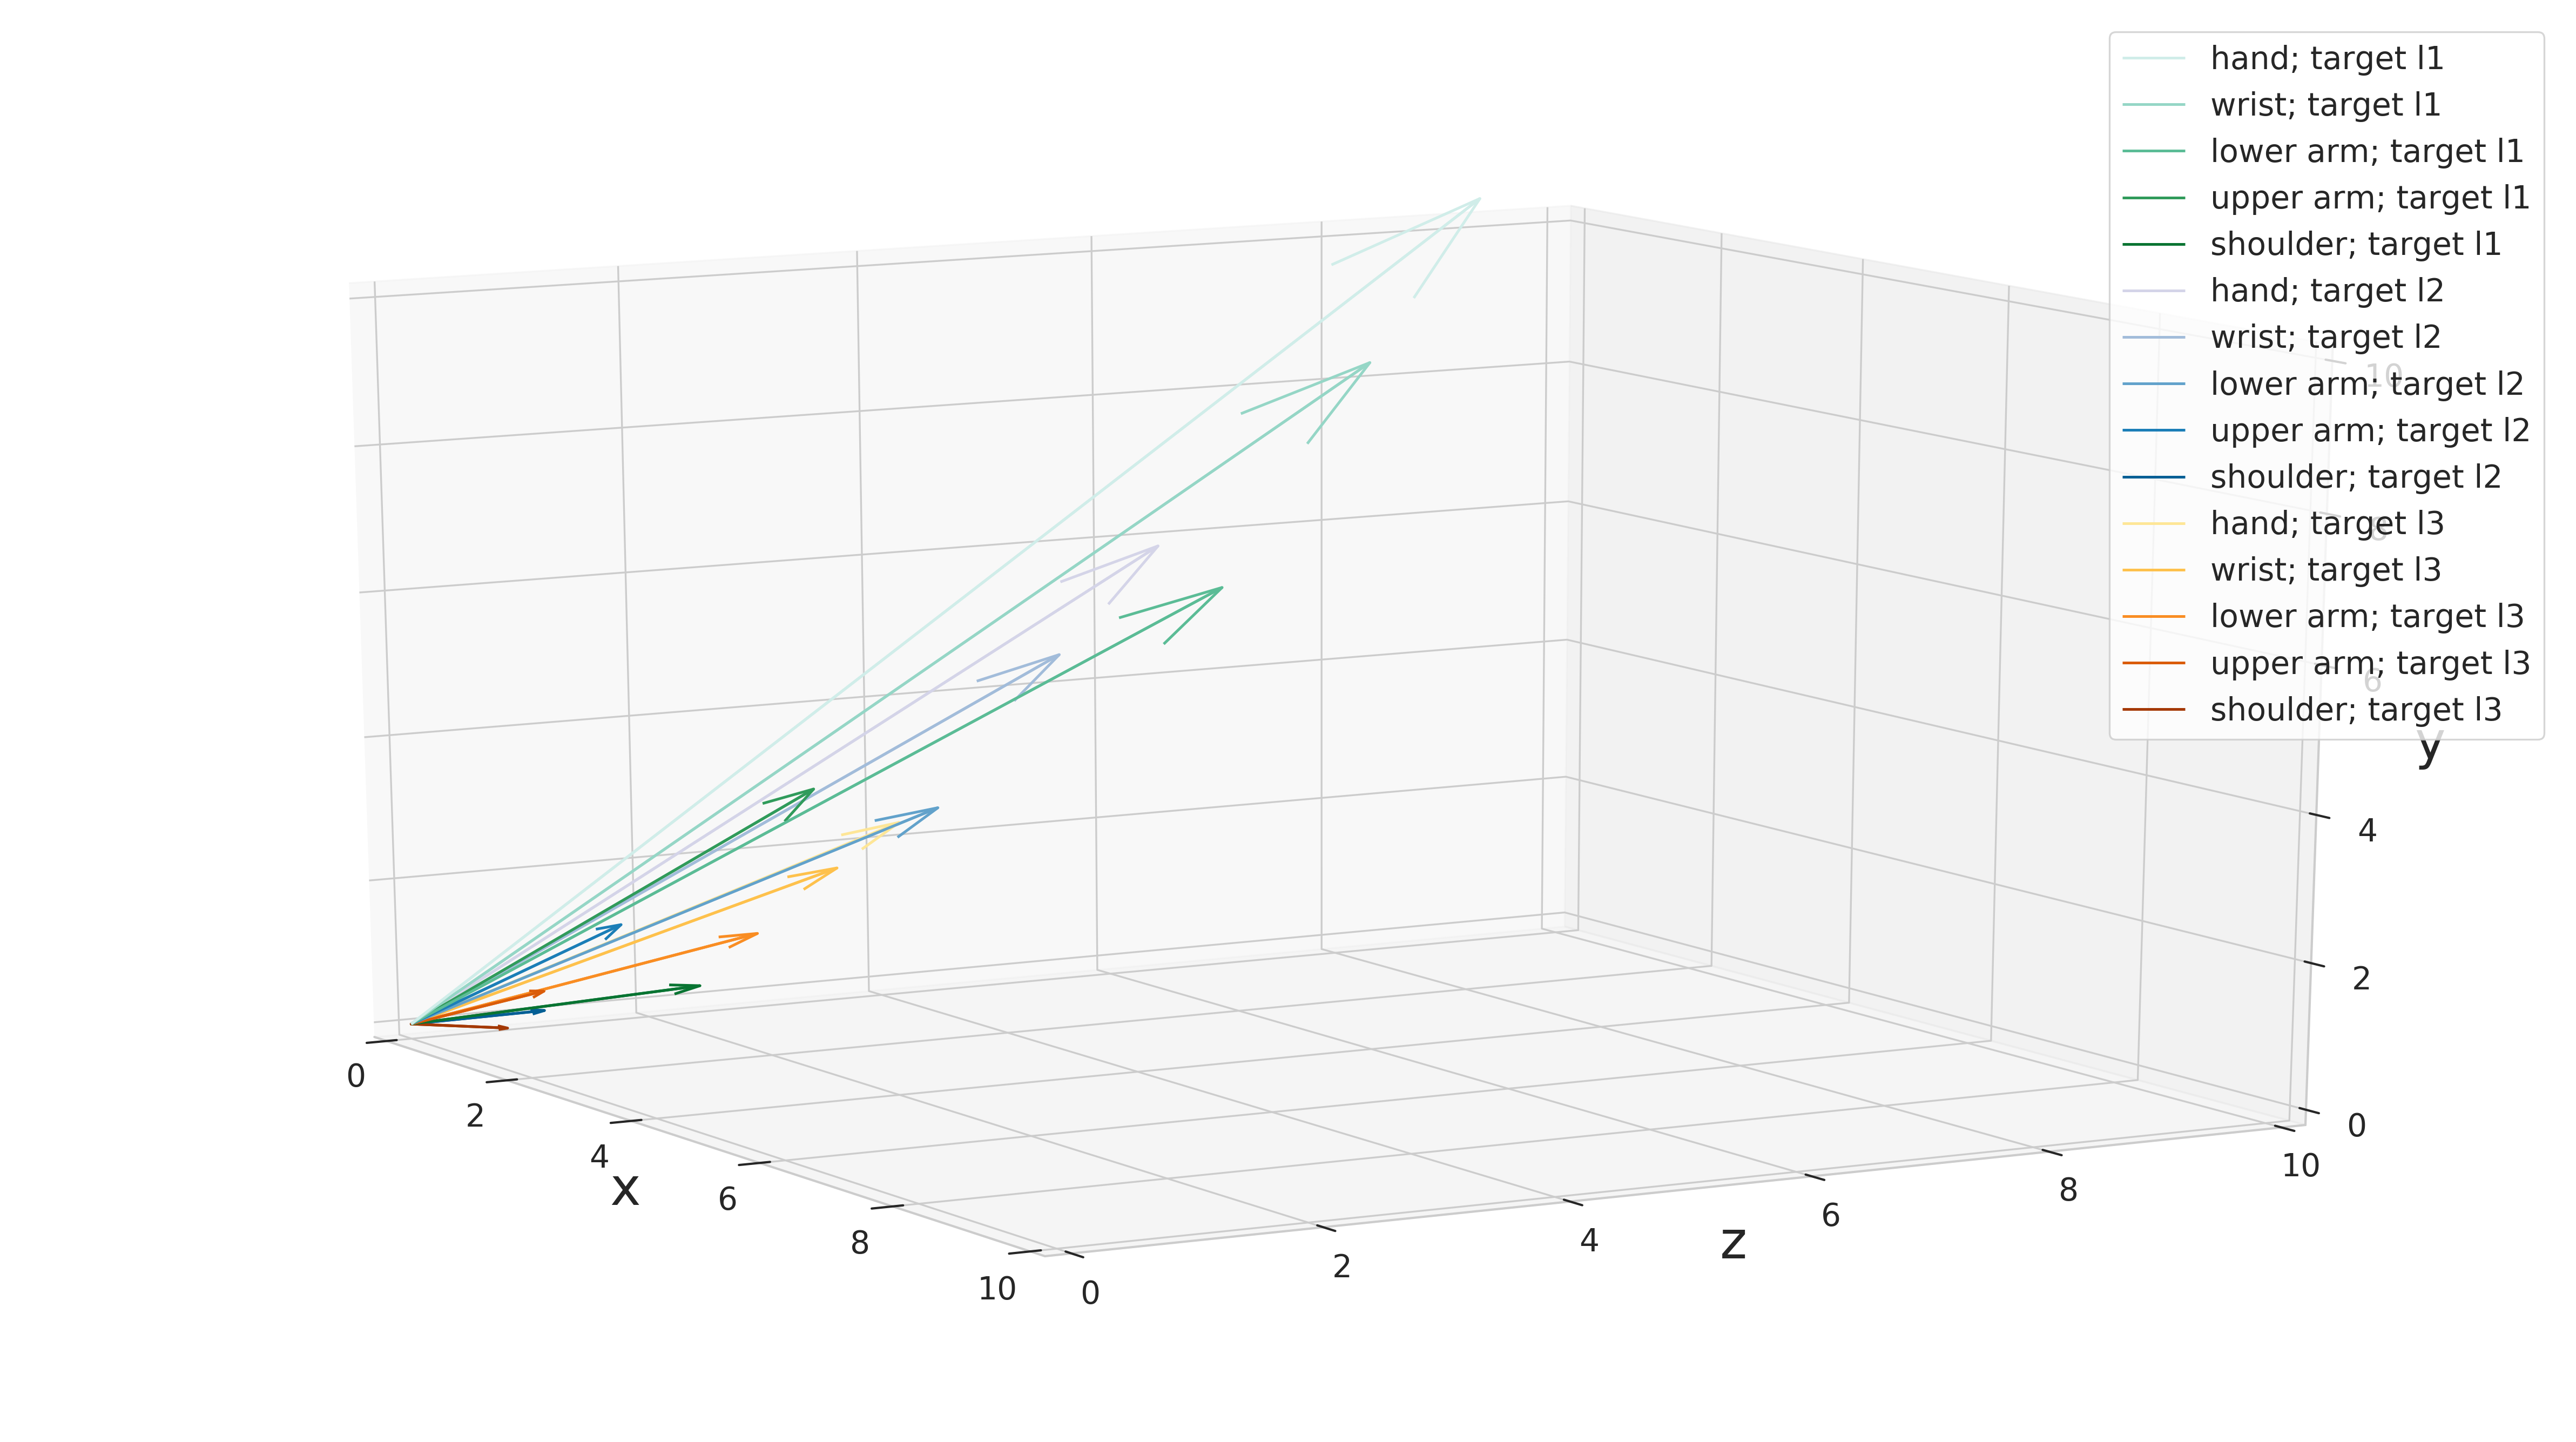

In [24]:
## PLOT FIRST SINGULAR VECTOR OF V
fig = plt.figure(figsize=(16,9))
# right hand

ax = fig.add_subplot(111, projection='3d')
counter = 0
for i in range(len(sv_r1)):
    if counter < 13:
        if counter == 0:
            c = palette1[2]
#             c = 'black'
            label = 'hand; target l1'
        elif counter == 3:
            c = palette1[4]
#             c = 'black'            
            label = 'wrist; target l1'
        elif counter == 6:
            c = palette1[6]
#             c = 'black'            
            label = 'lower arm; target l1'
        elif counter == 9:
            c = palette1[8]
#             c = 'black'            
            label = 'upper arm; target l1'
        elif counter == 12:
            c = palette1[10]
#             c = 'black'            
            label = 'shoulder; target l1'

        ax.plot(xs=(0,svt_l1[counter]), ys=(0,svt_l1[counter+2]), zs=(0,svt_l1[counter+1]), 
                color=c)
        ax.quiver(0,0, 0,svt_l1[counter],svt_l1[counter+2], svt_l1[counter+1], arrow_length_ratio=0.1,
                  label=label, color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(sv_r)):
    if counter < 13:
        if counter == 0:
            c = palette2[2]
#             c = 'maroon'            
            label = 'hand; target l2'
        elif counter == 3:
            c = palette2[4]
#             c = 'maroon'
            label = 'wrist; target l2'
        elif counter == 6:
            c = palette2[6]
#             c = 'maroon'
            label = 'lower arm; target l2'
        elif counter == 9:
            c = palette2[8]
#             c = 'maroon'            
            label = 'upper arm; target l2'
        elif counter == 12:
            c =palette2[10]
#             c = 'maroon'            
            label = 'shoulder; target l2'

        ax.plot(xs=(0,svt_l2[counter]), ys=(0,svt_l2[counter+2]), zs=(0,svt_l2[counter+1]), 
                 color=c)
        ax.quiver(0,0, 0,svt_l2[counter],svt_l2[counter+2], svt_l2[counter+1], arrow_length_ratio=0.1,
                  label=label, color=c)
        print(counter)

    counter += 3
    
counter = 0
for i in range(len(sv_r)):
    if counter < 13:
        if counter == 0:
            c = palette3[2]
#             c = 'navy'            
            label = 'hand; target l3'
        elif counter == 3:
            c = palette3[4]
#             c = 'navy'
            label = 'wrist; target l3'
        elif counter == 6:
            c = palette3[6]
#             c = 'navy'
            label = 'lower arm; target l3'
        elif counter == 9:
            c = palette3[8]
#             c = 'navy'
            label = 'upper arm; target l3'
        elif counter == 12:
            c = palette3[10]
#             c = 'navy'
            label = 'shoulder; target l3'

        ax.plot(xs=(0,svt_l3[counter]), ys=(0,svt_l3[counter+2]), zs=(0,svt_l3[counter+1]), 
                color=c, linestyle='-')
        ax.quiver(0,0, 0,svt_l3[counter],svt_l3[counter+2], svt_l3[counter+1], arrow_length_ratio=0.1,
                  label=label, color=c)
        print(counter)

    counter += 3



ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_zlim(0,10)


ax.set_xlabel('x', fontsize=23)
ax.set_ylabel('z', fontsize=23)
ax.set_zlabel('y', fontsize=23)
ax.view_init(azim=150)
# r1_line = mlines.Line2D([], [], color='Black', label='Kopfhöhe')
# r2_line = mlines.Line2D([], [], color='maroon', label='Schulterhöhe')
# r3_line = mlines.Line2D([], [], color='navy', label='Bauchhöhe')
# plt.legend(handles=[r1_line, r2_line, r3_line])
plt.legend()

try:
    os.makedirs('/home/michael/view_svt/l/'+subj+'/')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
    # get DATA

for deg in range(0,360,30):
    ax.view_init(elev=15., azim=deg)
    plt.savefig('/home/michael/view_svt/l/{a}/{a}_l_{b}d_svt.png'.format(a=subj, b=deg))

plt.show()